In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# !pip install FrEIA

In [2]:
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import grad
from torch.autograd.forward_ad import dual_level, make_dual, unpack_dual
import torchvision
from torchvision import transforms, datasets

import tqdm
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import sklearn
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import LogLocator
import math
import time
from IPython.display import clear_output
import types
import scipy
from itertools import product
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA

from collections import namedtuple
from math import sqrt, prod
from typing import Union, Callable

import FrEIA.framework as Ff
import FrEIA.modules as Fm

# import distributions as d
# import evaluation as e
# import models as m
# import loss as l

# import optuna
# from optuna.trial import TrialState

# evaluation.py

In [ ]:
import torch
import matplotlib.pyplot as plt
import distributions as d # neel: I had  to write it myself to stay consistent with this notebook's work
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

device = 'cpu'

# this KL is only for make moons dataset
def kldiv(model, batchsize=500, encoder=None, normalized=False, cvf=False, no_ljd=False):
    moons_dist = d.moons_gmm(components=1000, noise=0.17)
    kldiv = torch.nn.KLDivLoss(log_target=True, reduction="batchmean")
    x, _ = make_moons(batchsize, noise=0.1)
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(x)
    x = torch.Tensor(x_normalized)
    target = torch.Tensor(moons_dist.log_prob(x)).float().to(device)
    if not cvf: # if model's output is logprob
        if encoder is not None:
            if not no_ljd:
                z, _ = encoder(x)
            else:
                z = encoder(x)
            pred = model(z).squeeze()
        else: pred = model(x).squeeze()
    else: pred = model.logprob(x) # if model has logprob method:
    if normalized: return kldiv(pred, target)
    else: return generalized_kl(pred, target)

def generalized_kl(input, target):
    """based on "SBI with generalized KLD, Miller et al 23"""
    return target.exp() * (target - input + input.exp()/target.exp() -1)

def mmd_inverse_multi_quadratic(x, y, bandwidths=None):
    batch_size = x.size()[0]
    # compute the kernel matrices for each combination of x, y
    # (cleverly using broadcasting to do this efficiently)
    xx, yy, xy = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    # compute the sum of kernels at different bandwidths
    K, L, P = 0, 0, 0
    if bandwidths is None:
        bandwidths = [0.4, 0.8, 1.6]
    for sigma in bandwidths:
        s = 1.0 / sigma**2
        K += 1.0 / (1.0 + s * (rx.t() + rx - 2.0*xx))
        L += 1.0 / (1.0 + s * (ry.t() + ry - 2.0*yy))
        P += 1.0 / (1.0 + s * (rx.t() + ry - 2.0*xy))

    beta = 1./(batch_size*(batch_size-1)*len(bandwidths))
    gamma = 2./(batch_size**2 * len(bandwidths))
    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)


# PLOTTING


def contour_plot(model, ax=None, encoder=None, batchsize=100, cvf=False, no_ljd=False, colorbar=True):
    """_summary_
    Args:
        model: Model which calculates logprobs (regressor or, if cvf=True, an INN)
        ax (plt.ax, optional): ax for plotting. Defaults to None.
        encoder, optional): Model which turns x to latent z. Defaults to None.
        batchsize (int, optional): Defaults to 100.
        cvf (bool, optional): Whether model is a regressor or an INN. Defaults to False.
    """
    grid = torch.stack(torch.meshgrid(torch.linspace(-2., 2., 100), torch.linspace(-2., 2., 100), indexing='xy'))
    # convert the grid to a batch of 2d points:
    grid = grid.reshape(2, -1).T
    # get the output on all points in the grid
    if not cvf:
        if encoder is None:
            out = torch.exp(model(grid))
        else:
            if not no_ljd: z, _ = encoder(grid)
            else: z = encoder(grid)
            out = torch.exp(model(z))
    if cvf:
        out = torch.exp(model.logprob(grid))
    # plot
    if ax is None:
        cax = plt.matshow(out.detach().numpy().reshape(100,100))
        plt.axis("off")
        if colorbar: cbar = plt.colorbar(cax)
        plt.show()
    else:
        cax = ax.matshow(out.detach().numpy().reshape(100,100))
        ax.axis("off")
        if colorbar: cbar = plt.colorbar(cax, fraction=0.046, pad=0.04)
    return cax

def plot_inn_samples(model, title="Generated samples from INN", axs=None, show_true=False):
    samples = model.sample(1000)
    samples = samples.detach().numpy()
    if axs is None:
        fig, axs = plt.subplots(1,1)
    axs.scatter(samples[:,0], samples[:,1], color="blue", label="sampled", s=6)
    if show_true:
        x, _ = make_moons(1000, noise=0.1, shuffle=True)
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        axs.scatter(x[:,0], x[:,1], color="orange", label="true", s=6)
    axs.set_title(title)
    axs.legend()


# models.py

In [4]:
from scipy.stats import special_ortho_group # neel: This import was missing. needed for orthogonal_matrix function
from functorch import jacrev, vmap # neel: This import was missing. needded for FreeFormFlow class

In [ ]:
def make_regressor(n_dim, hidden_dim, n_layers):
    mle_layers = [nn.Linear(n_dim, hidden_dim), nn.ReLU()]
    for _ in range(n_layers):
        mle_layers.append(nn.Linear(hidden_dim, hidden_dim))
        mle_layers.append(nn.ReLU())
    mle_layers.append(nn.Linear(hidden_dim, 1))
    return nn.Sequential(*mle_layers)


#### INN ###########################################################################

def subnet_constructor(input_size, hidden_size, output_size, dropout, n_hidden_layers):
    layers = nn.Sequential()
    layers.append(nn.Dropout(p=dropout))
    layers.append(nn.Linear(input_size, hidden_size))
    layers.append(nn.PReLU())
    for _ in range(n_hidden_layers):
        layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(nn.PReLU())
    layers.append(nn.Dropout(p=dropout))
    layers.append(nn.Linear(hidden_size, output_size))

    return layers

def ortogonal_matrix(dim):
    Q = special_ortho_group.rvs(dim)# Neel: scipy import was missing earlier
    return torch.Tensor(Q)



## Undefined things in train_inn fn: 1. cond, 2. e.mmd_inverse_multi_quadratic, 3. e in e.generalized_kl.
## update: 2. and 3. are implemented under the section evaluation.py. one can maybe remove 'e' in the argument below
def train_inn(model, batchsize=1000, epochs=20, lr=0.001, track_kl=True,
              calculate_mmd=False, trial=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    gmm = d.moons_gmm()

    metrics = {}
    loss_history = []
    mmd_history = []
    mmd_epochs = []
    kl_history = []
    kl_epochs = []
    model_screenshots = []

    for epoch in tqdm.tqdm(range(epochs)):
        optimizer.zero_grad()
        model.train()
        
        x, _ = make_moons(n_samples=batchsize, shuffle=True, noise=0.1)
        scaler = StandardScaler()
        x_normalized = scaler.fit_transform(x)
        x = torch.tensor(x_normalized, dtype=torch.float32)

        z, ljd = model(x)

        loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize

        loss.backward()
        loss_history.append(loss.item())

        optimizer.step()


        if epoch%20 == 0:
            model.eval()
            if calculate_mmd:
                mmd_history.append(e.mmd_inverse_multi_quadratic(x, model.sample(batchsize, cond=cond)).item())
                mmd_epochs.append(epoch)
            if track_kl:
                target = torch.Tensor(gmm.log_prob(x))
                kl_history.append(e.generalized_kl(model.logprob(x, cond=cond), target).mean().item())
                kl_epochs.append(epoch)
        if ((epoch+1) % (epochs//5))==0:
            model_screenshots.append(copy.deepcopy(model))
        if trial is not None: trial.report(loss.item(), epoch)
    metrics["inn_loss"] = loss_history
    if calculate_mmd: metrics["mmd"] = (mmd_epochs, mmd_history)
    if track_kl: metrics["kl"] = (kl_epochs, kl_history)
    return model, metrics, model_screenshots

class coupling_block(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, subnet_hidden_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.split1 = math.floor(self.input_size/2)
        self.split2 = self.input_size - self.split1

        self.subnet = subnet_constructor(self.split1, self.hidden_size, 2*self.split2, dropout, subnet_hidden_layers)

    def forward(self, x, rev=False):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]

        params = self.subnet(x1)
        s, t = params[...,:self.split2], params[...,self.split2:]
        s = torch.tanh(s)
        ljd = torch.sum(s, -1)


        if not rev:
            s = torch.exp(s)
            x2 = s*x2 + t
            return torch.cat([x1,x2], -1), ljd
        if rev:
            s = torch.exp(-s)
            x2 = s * (x2-t)
            return torch.cat([x1,x2], -1)

class realNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, dropout=0.0, subnet_hidden_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks

        self.coupling_blocks = nn.ModuleList([coupling_block(input_size,
                                                             hidden_size,
                                                             dropout,
                                                             subnet_hidden_layers=subnet_hidden_layers).to(device)
                                              for _ in range(n_blocks)])
        self.orthogonal_matrices = [ortogonal_matrix(input_size).to(device) for _ in range(n_blocks-1)]

    def forward(self, x, rev=False, cond=None):
        if x.dim() == 1: x = x.unsqueeze(0)
        if rev: return self._inverse(x)
        return self._forward(x)

    def _forward(self, x):
        ljd = torch.zeros((x.shape[0])).to(device)
        for l in range(self.n_blocks-1):
            x, partial_ljd = self.coupling_blocks[l](x)
            ljd += partial_ljd
            x = torch.matmul(x, self.orthogonal_matrices[l])
        x, partial_ljd = self.coupling_blocks[-1](x)
        ljd += partial_ljd
        return x, ljd

    def _inverse(self, x):
        for l in range (self.n_blocks-1, 0, -1):
            x = self.coupling_blocks[l](x, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[l-1].T)
        x = self.coupling_blocks[0](x, rev=True)
        return x

    def sample(self, num_samples, cond=None):
        z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size))).to(device)
        return self._inverse(z)

    def logprob(self, x, cond=None, verbose=False):
        z, ljd = self.forward(x)
        if verbose:
            return - 0.5*torch.sum(z**2, -1) + ljd - 0.5 * z.shape[1] * np.log(2*math.pi), - 0.5*torch.sum(z**2, -1) - 0.5 * z.shape[1] * np.log(2*math.pi), ljd
        return - 0.5*torch.sum(z**2, -1) + ljd - 0.5 * z.shape[1] * np.log(2*math.pi)


########### FFF Stuff ###############################################################

class resnet(nn.Module):
  def __init__(self, input_dim, hidden_dim, n_blocks, output_dim, hidden_layers):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.n_blocks = n_blocks
    self.output_dim = output_dim
    self.hidden_layers = hidden_layers
    self.blocks = nn.ModuleList()

    self.first_layer = nn.Linear(self.input_dim, self.hidden_dim)

    for _ in range(self.n_blocks):
      layers = []
      for i in range(self.hidden_layers):
        if not i==0:
            layers.append(nn.SiLU())
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
      self.blocks.append(
          nn.Sequential(*layers))
            # nn.Linear(self.hidden_dim, self.hidden_dim), nn.SiLU(),
            # nn.Linear(self.hidden_dim, self.hidden_dim), nn.SiLU(),
            # nn.Linear(self.hidden_dim, self.hidden_dim), nn.SiLU(),
            # nn.Linear(self.hidden_dim, self.hidden_dim), nn.SiLU()))

    self.last_layer = nn.Linear(self.hidden_dim, self.output_dim)

  def forward(self, input):
    input = self.first_layer(input)
    for b in range(self.n_blocks):
      residual = self.blocks[b](input)
      input = input + residual
    return self.last_layer(input)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_hidden_layers=1, device="cpu"):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList()
        self.n_hidden_layers = n_hidden_layers
        for _ in range(self.n_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.SiLU()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = device

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        for i in range(self.n_hidden_layers):
            x = self.relu(self.hidden_layers[i](x))
        x = self.output_layer(x)
        return x

# previosuly undefined (FIXED NOW): vmap, jacrev. However they are the part of module functorch. 
# undefined: l.nll_surrogate: UPDATE: nll_surrogate is also defined in the code cell: loss.py
class FreeFormFlow(torch.nn.Module):
    def __init__(self, encoder, decoder, data_dims=2, device="cpu"):
        super().__init__()
        #self.encoder = MLP(input_dim, hidden_dim, output_dim, n_hidden_layers=n_hidden_layers)
        #self.decoder = MLP(output_dim, hidden_dim, input_dim, n_hidden_layers=n_hidden_layers)
        #self.encoder = resnet(input_dim=input_dim, hidden_dim=hidden_dim, n_blocks=n_blocks, output_dim=output_dim)
        #self.decoder = resnet(input_dim=input_dim, hidden_dim=hidden_dim, n_blocks=n_blocks, output_dim=output_dim)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = encoder.input_dim
        self.output_dim = encoder.output_dim
        self.data_dims = data_dims
        self.device = device

    def forward(self, x_or_z, rev=False, cond=None):
        if rev: return self.decoder(x_or_z)
        else: return self.encoder(x_or_z)

    def sample(self, num_samples, cond=None):
        z = torch.normal(mean=torch.zeros((num_samples, self.input_dim)), std=torch.ones((num_samples, self.input_dim))).to(device)
        return self.decoder(z)[..., :self.data_dims]

    def logprob(self, x, exact=True, jac_of_enc=True, cond=None, verbose=False):
        if exact:
            if x.dim() == 1:
                x = x.unsqueeze(0)
            z = self.encoder(x)
            z = z[..., :self.data_dims]
            latent_logprob = - 0.5*torch.sum(z**2, -1) - 0.5 * z.shape[1] * np.log(2*math.pi)
            if jac_of_enc:
                jac = vmap(jacrev(self.encoder))(x)
                jac = jac[:, :self.data_dims, :]
            else:
                jac = vmap(jacrev(self.decoder))(z)
                jac = jac[:, :self.data_dims, :]
            ljd = torch.linalg.slogdet(jac)
            if verbose: return latent_logprob + ljd[1], latent_logprob, ljd[1]
            return latent_logprob + ljd[1]

        else:
            return l.nll_surrogate(x, self.encoder, self.decoder)[3]

    def ljd(self, x, cond=None):
      jac = vmap(jacrev(self.encoder))(x)
      jac = jac[:, :self.data_dims, :]
      ljd = torch.linalg.slogdet(jac)
      return ljd

class brazy_encoder(nn.Module):
    def __init__(self, c_small=32, f1_dim=512, f2_dim=1024, input_dim=28*28, output_dim=28*28, batchnorm=True, third_conv=False, p_dropout=0.0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.c1 = c_small
        self.c2 = 2*c_small
        if third_conv:
            self.c3 = 4*c_small
        else:
            self.c3 = self.c2
        self.f1_dim = f1_dim
        self.f2_dim = f2_dim
        self.batchnorm = batchnorm
        self.third_conv = third_conv
        self.p_dropout=p_dropout

        self.dropout = nn.Dropout(self.p_dropout)

        self.conv1 = nn.Conv2d(1, self.c1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.c1, self.c2, kernel_size=3, padding=1)
        if third_conv:
            self.conv3 = nn.Conv2d(self.c2, self.c3, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7 * 7 * self.c3, self.f1_dim)
        self.fc2 = nn.Linear(self.f1_dim, self.f2_dim)
        self.latent = nn.Linear(self.f2_dim, self.output_dim)

        if self.batchnorm:
            self.batchnorm1 = nn.BatchNorm2d(self.c1)
            self.batchnorm2 = nn.BatchNorm2d(self.c2)
        else:
            self.batchnorm1 = nn.Identity()
            self.batchnorm2 = nn.Identity()


    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)
        x = nn.functional.relu(self.batchnorm1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout(x)
        x = nn.functional.relu(self.batchnorm2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout(x)
        if self.third_conv:
            x = nn.functional.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        return self.latent(x)

class brazy_decoder(nn.Module):
    def __init__(self, c_small=32, f1_dim=512, f2_dim=1024, input_dim=28*28, output_dim=28*28, batchnorm=True, third_conv=True, p_dropout=0.0):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.c1 = c_small
        self.c2 = 2*c_small
        if third_conv:
            self.c3 = 4*c_small
        else:
            self.c3 = self.c2
        self.f1_dim = f1_dim
        self.f2_dim = f2_dim
        self.batchnorm = batchnorm
        self.third_conv = third_conv
        self.p_dropout = p_dropout

        self.dropout = nn.Dropout(self.p_dropout)

        self.fc2 = nn.Linear(self.input_dim, self.f2_dim)  # Opposite of Encoder's latent layer
        self.fc1 = nn.Linear(self.f2_dim, self.f1_dim)
        self.fc_to_conv = nn.Linear(self.f1_dim, 7 * 7 * self.c3)  # Convert back to the flattened conv output size

        if third_conv:
            self.deconv3 = nn.ConvTranspose2d(self.c3, self.c2, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(self.c2, self.c1, kernel_size=3, padding=1)
        self.deconv1 = nn.ConvTranspose2d(self.c1, 1, kernel_size=3, padding=1)

        if self.batchnorm:
            self.batchnorm1 = nn.BatchNorm2d(self.c1)
            self.batchnorm2 = nn.BatchNorm2d(self.c2)
        else:
            self.batchnorm1 = nn.Identity()
            self.batchnorm2 = nn.Identity()

    def forward(self, z):
        # Fully connected layers (reverse of encoder's)
        z = nn.functional.relu(self.fc2(z))
        z = self.dropout(z)
        z = nn.functional.relu(self.fc1(z))
        z = self.dropout(z)
        # Reshape back to a 3D tensor (for convolution layers)
        z = self.fc_to_conv(z)
        z = z.view(z.shape[0], self.c3, 7, 7)  # Reshape to match conv output

        # Upsample through transposed convolutions
        z = nn.functional.interpolate(z, scale_factor=2)  # Upsample to 14x14
        if self.third_conv:
            z = nn.functional.relu(self.deconv3(z))
        z = nn.functional.relu(self.deconv2(self.batchnorm2(z)))
        z = self.dropout(z)

        z = nn.functional.interpolate(z, scale_factor=2)  # Upsample to 28x28
        z = self.deconv1(self.batchnorm1(z))
        z = z.reshape(-1, 784)
        return z

class cond_conv_encoder(nn.Module):
    def __init__(self, c_small=32, f1_dim=512, f2_dim=1024, input_dim=28*28,
                 output_dim=28*28, batchnorm=True, third_conv=False, cond_dim=10,
                 p_dropout=0.0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.c1 = c_small
        self.c2 = 2*c_small
        if third_conv:
            self.c3 = 4*c_small
        else:
            self.c3 = self.c2
        self.f1_dim = f1_dim
        self.f2_dim = f2_dim
        self.batchnorm = batchnorm
        self.third_conv = third_conv
        self.cond_dim = cond_dim
        self.p_dropout = p_dropout

        self.dropout = nn.Dropout(self.p_dropout)

        self.conv1 = nn.Conv2d(1, self.c1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.c1, self.c2, kernel_size=3, padding=1)
        if third_conv:
            self.conv3 = nn.Conv2d(self.c2, self.c3, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7 * 7 * self.c3 + self.cond_dim, self.f1_dim)
        self.fc2 = nn.Linear(self.f1_dim + self.cond_dim, self.f2_dim)
        #self.fc3 = nn.Linear(self.f2_dim + self.cond_dim, self.f2_dim)
        self.latent = nn.Linear(self.f2_dim + self.cond_dim, self.output_dim)

        if self.batchnorm:
            self.batchnorm1 = nn.BatchNorm2d(self.c1)
            self.batchnorm2 = nn.BatchNorm2d(self.c2)
        else:
            self.batchnorm1 = nn.Identity()
            self.batchnorm2 = nn.Identity()


    def forward(self, x, cond):
        x = x.reshape(-1, 1, 28, 28)
        x = self.dropout(x)
        x = nn.functional.relu(self.batchnorm1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout(x)
        x = nn.functional.relu(self.batchnorm2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        if self.third_conv:
            x = nn.functional.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(self.add_cond_to_x(x, cond)))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(self.add_cond_to_x(x, cond)))
        x = self.dropout(x)
        #x = nn.functional.relu(self.fc3(self.add_cond_to_x(x, cond)))
        return self.latent(self.add_cond_to_x(x,cond))

    def add_cond_to_x(self, x, cond):
        assert cond.shape[-1] == self.cond_dim
        assert cond.shape[0] == x.shape[0]
        return torch.cat([x, cond], dim=-1)

class cond_conv_decoder(nn.Module):
    def __init__(self, c_small=32, f1_dim=512, f2_dim=1024, input_dim=28*28,
                 output_dim=28*28, batchnorm=True, third_conv=True, cond_dim=10,
                 p_dropout=0.0):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.c1 = c_small
        self.c2 = 2*c_small
        if third_conv:
            self.c3 = 4*c_small
        else:
            self.c3 = self.c2
        self.f1_dim = f1_dim
        self.f2_dim = f2_dim
        self.batchnorm = batchnorm
        self.third_conv = third_conv
        self.cond_dim = cond_dim
        self.p_dropout = p_dropout

        self.dropout = nn.Dropout(self.p_dropout)

        self.fc3 = nn.Linear(self.input_dim+self.cond_dim, self.f2_dim)
        #self.fc2 = nn.Linear(self.f2_dim+self.cond_dim, self.f2_dim)  # Opposite of Encoder's latent layer
        self.fc1 = nn.Linear(self.f2_dim+self.cond_dim, self.f1_dim)
        self.fc_to_conv = nn.Linear(self.f1_dim+self.cond_dim, 7 * 7 * self.c3)  # Convert back to the flattened conv output size

        if third_conv:
            self.deconv3 = nn.ConvTranspose2d(self.c3, self.c2, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(self.c2, self.c1, kernel_size=3, padding=1)
        self.deconv1 = nn.ConvTranspose2d(self.c1, 1, kernel_size=3, padding=1)

        if self.batchnorm:
            self.batchnorm1 = nn.BatchNorm2d(self.c1)
            self.batchnorm2 = nn.BatchNorm2d(self.c2)
        else:
            self.batchnorm1 = nn.Identity()
            self.batchnorm2 = nn.Identity()

    def forward(self, z, cond):
        # Fully connected layers (reverse of encoder's)
        z = self.dropout(z)
        z = nn.functional.relu(self.fc3(self.add_cond_to_z(z, cond)))
        #z = nn.functional.relu(self.fc2(self.add_cond_to_z(z, cond)))
        z = self.dropout(z)
        z = nn.functional.relu(self.fc1(self.add_cond_to_z(z, cond)))

        # Reshape back to a 3D tensor (for convolution layers)
        z = self.dropout(z)
        z = self.fc_to_conv(self.add_cond_to_z(z,cond))
        z = z.view(z.shape[0], self.c3, 7, 7)  # Reshape to match conv output

        # Upsample through transposed convolutions
        z = nn.functional.interpolate(z, scale_factor=2)  # Upsample to 14x14
        z = self.dropout(z)
        if self.third_conv:
            z = nn.functional.relu(self.deconv3(z))
        z = self.dropout(z)
        z = nn.functional.relu(self.deconv2(self.batchnorm2(z)))

        z = nn.functional.interpolate(z, scale_factor=2)  # Upsample to 28x28
        z = self.dropout(z)
        z = self.deconv1(self.batchnorm1(z))
        z = z.reshape(-1, 784)
        return z

    def add_cond_to_z(self, z, cond):
        assert cond.shape[-1] == self.cond_dim
        assert cond.shape[0] == z.shape[0]
        return torch.cat([z, cond], dim=-1)

## undefined: l.nll_surrogate
## UPDATE: nll_surrogate is defined in the cell under the section: loss.py
class condFreeFormFlow(torch.nn.Module):
    def __init__(self, encoder, decoder, cond_dim=10, data_dims=2, device="cpu"):
        super().__init__()
        #self.encoder = MLP(input_dim, hidden_dim, output_dim, n_hidden_layers=n_hidden_layers)
        #self.decoder = MLP(output_dim, hidden_dim, input_dim, n_hidden_layers=n_hidden_layers)
        #self.encoder = resnet(input_dim=input_dim, hidden_dim=hidden_dim, n_blocks=n_blocks, output_dim=output_dim)
        #self.decoder = resnet(input_dim=input_dim, hidden_dim=hidden_dim, n_blocks=n_blocks, output_dim=output_dim)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = encoder.input_dim
        self.output_dim = encoder.output_dim
        self.data_dims = data_dims
        self.cond_dim = cond_dim
        self.device = device

    def forward(self, x_or_z, cond, rev=False):
        if rev: return self.decoder(x_or_z, cond)
        else: return self.encoder(x_or_z, cond)

    def sample(self, batchsize, cond):
        assert cond.shape[0] == batchsize
        assert cond.shape[1] == self.cond_dim
        num_samples = cond.shape[0]
        z = torch.normal(mean=torch.zeros((num_samples, self.input_dim)), std=torch.ones((num_samples, self.input_dim))).to(device)
        return self.decoder(z, cond)[..., :self.data_dims]

    def logprob(self, x, cond, exact=True, jac_of_enc=True):
        if exact:
            if x.dim() == 1:
                x = x.unsqueeze(0)
            z = self.encoder(x)
            z = z[..., :self.data_dims]
            latent_logprob = - 0.5*torch.sum(z**2, -1) - 0.5 * z.shape[1] * np.log(2*math.pi)
            if jac_of_enc:
                jac = vmap(jacrev(self.encoder))(x)
                jac = jac[:, :self.data_dims, :]
            else:
                jac = vmap(jacrev(self.decoder))(z)
            ljd = torch.linalg.slogdet(jac)
            return latent_logprob + ljd[1]
        else:
            return l.nll_surrogate(x, self.encoder, self.decoder)[3]

# loss.py

In [ ]:
SurrogateOutput = namedtuple("SurrogateOutput", ["z", "x1", "nll", "surrogate", "regularizations"])
LossOutput = namedtuple("LossOutput", ["loss", "x", "x_rec", "nll", "z", "surrogate"])
Transform = Callable[[torch.Tensor], torch.Tensor]


def sample_v(x: torch.Tensor, hutchinson_samples: int):
    """
    Sample a random vector v of shape (*x.shape, hutchinson_samples)
    with scaled orthonormal columns.

    The reference data is used for shape, device and dtype.

    :param x: Reference data.
    :param hutchinson_samples: Number of Hutchinson samples to draw.
    :return:
    """
    batch_size, total_dim = x.shape[0], prod(x.shape[1:])
    if hutchinson_samples > total_dim:
        raise ValueError(f"Too many Hutchinson samples: got {hutchinson_samples}, expected <= {total_dim}")
    v = torch.randn(batch_size, total_dim, hutchinson_samples, device=x.device, dtype=x.dtype)
    q = torch.linalg.qr(v).Q.reshape(*x.shape, hutchinson_samples) #neel: can we extract like this? if yes, then it is correct–
    return q * sqrt(total_dim)


def nll_surrogate(x: torch.Tensor, encode: Transform, decode: Transform,
                  hutchinson_samples: int = 1, cond=None) -> SurrogateOutput:
    """
    Compute the per-sample surrogate for the negative log-likelihood and the volume change estimator.
    The gradient of the surrogate is the gradient of the actual negative log-likelihood.

    :param x: Input data. Shape: (batch_size, ...)
    :param encode: Encoder function. Takes `x` as input and returns a latent representation of shape (batch_size, latent_dim).
    :param decode: Decoder function. Takes a latent representation of shape (batch_size, latent_dim) as input and returns a reconstruction of shape (batch_size, ...).
    :param hutchinson_samples: Number of Hutchinson samples to use for the volume change estimator.
    :param manifold: Manifold on which the latent space lies. If provided, the volume change is computed on the manifold.
    :return: Per-sample loss. Shape: (batch_size,)
    """
    data_dim = x.shape[-1]
    if cond is not None:
        cond_dim = cond.shape[-1]
    x.requires_grad_()

    if cond is not None:
        z = encode(x, cond)
    else:
        z = encode(x)
    z_red = z[..., :data_dim]

    metrics = {}

    surrogate = 0
    vs = sample_v(z_red, hutchinson_samples)

    for k in range(hutchinson_samples):
        v = vs[..., k]
        if cond is not None:
            v_red = v[...,:data_dim + cond_dim]
        else:
            v_red = v[..., :data_dim]

        # $ g'(z) v $ via forward-mode AD
        with dual_level():
            dual_z = make_dual(z_red, v_red)
            if cond is None:
                dual_x1 = decode(dual_z)
            if cond is not None:
                dual_x1 = decode(dual_z, cond)

            x1, v1 = unpack_dual(dual_x1)
            v1_red = v1[...,:data_dim]

        # $ v^T f'(x) $ via backward-mode AD
        v2, = grad(z_red, x, v, create_graph=True)
        v2_red = v2[...,:data_dim]

        # $ v^T f'(x) stop_grad(g'(z)) v $
        v2_red = v2_red.reshape((v2_red.shape[0], -1))
        v1_red = v1_red.reshape((v1_red.shape[0], -1))
        surrogate += sum_except_batch(v2_red * v1_red.detach()) / hutchinson_samples

    # Per-sample negative log-likelihood
    nll = sum_except_batch((z ** 2)) / 2 - surrogate

    return SurrogateOutput(z, x1, nll, surrogate, metrics)


def fff_loss(x: torch.Tensor,
             encode: Transform, decode: Transform,
             beta: Union[float, torch.Tensor],
             hutchinson_samples: int = 1,
             cond = None
             ) -> torch.Tensor:
    """
    Compute the per-sample FFF/FIF loss:
    $$
    \mathcal{L} = \beta ||x - decode(encode(x))||^2 + ||encode(x)||^2 // 2 - \sum_{k=1}^K v_k^T f'(x) stop_grad(g'(z)) v_k
    $$
    where $E[v_k^T v_k] = 1$, and $ f'(x) $ and $ g'(z) $ are the Jacobians of `encode` and `decode`.

    :param x: Input data. Shape: (batch_size, ...)
    :param encode: Encoder function. Takes `x` as input and returns a latent representation of shape (batch_size, latent_dim).
    :param decode: Decoder function. Takes a latent representation of shape (batch_size, latent_dim) as input and returns a reconstruction of shape (batch_size, ...).
    :param beta: Weight of the mean squared error.
    :param hutchinson_samples: Number of Hutchinson samples to use for the volume change estimator.
    :param fff_loss_dims: The first n dimensions of x_tilde that are to be trained with the FFF-loss.
    :param l: Weight of the regression loss for extra outputs (e.g. change-of-variables term).
    :return: Per-sample loss. Shape: (batch_size,)
    """
    data_dim = x.shape[-1]

    if cond is not None:
        surrogate = nll_surrogate(x, encode, decode, hutchinson_samples, cond=cond)
    else:
        surrogate = nll_surrogate(x, encode, decode, hutchinson_samples)

    x1_red = surrogate.x1[...,:data_dim]
    x = x.flatten(start_dim=1)
    mse = torch.sum((x - x1_red) ** 2, dim=tuple(range(1, len(x.shape))))
    loss = beta * mse + surrogate.nll
    return LossOutput(loss, x, x1_red, surrogate.nll, surrogate.z, surrogate.surrogate)


def sum_except_batch(x: torch.Tensor) -> torch.Tensor:
    """
    Sum over all dimensions except the first.
    :param x: Input tensor.
    :return: Sum over all dimensions except the first.
    """
    return torch.sum(x.reshape(x.shape[0], -1), dim=1)

# Function for dataloaders

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'

def get_mnist_dataloaders(batchsize, pixelwidth, digit=None, zero_one_range=False):
    if not zero_one_range:
        transform = transforms.Compose([
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Resize((pixelwidth, pixelwidth)),
            transforms.Normalize((0.1307,), (0.3081,)),  # Normalize the images
            AddGaussianNoise(mean=0.0, std=0.01),
            transforms.Lambda(lambda x: x.view(-1))
        ])
    if zero_one_range:
        transform = transforms.Compose([
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Resize((pixelwidth, pixelwidth)),
            transforms.Lambda(lambda x: x.view(-1))
        ])


    # Download and load the training data
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Download and load the test data
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if digit is not None:
        # Filter training dataset for the specific digit
        train_indices = [i for i, label in enumerate(train_dataset.targets) if label == digit]
        train_dataset = torch.utils.data.Subset(train_dataset, train_indices)

        # Filter test dataset for the specific digit
        test_indices = [i for i, label in enumerate(test_dataset.targets) if label == digit]
        test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

    # Create data loaders for batching and shuffling
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

    return train_loader, test_loader

# Training function for INN, FFF and aFFF

In [ ]:
# (UPDATE: found their implementations (:))Undefined thing: 1. pca.inverse_transform, 2. acfff_prob_teacher, 3. get_fid_for_model, 4. check_acfff_classification_output, 5. get_inception_score_for_model
# UPDATE: WE HAVE IMPORTED PCA FROM SKLEARN.DECOMPOSITION. create an instance: pca = PCA(num_componets) and  then one can use pca.invese_transform
# UPDATE: acfff_prob_teacher  is defined in the cell section 'Cond-FFF 2.0', on line 10 (acfff_prob_teacher = ImprovedCNN().to(device))
# UPDATE: get_fid_for_model is  defined in the cell just  before the section 'Inception score'
# UPDATE: Check_acfff_classification_output: this function is also defined under the section: Function to evaluate acFFF output for all digits
# UPDATE: get_inception_score_for_model: is defined in the cell under the section Inception score
def train_model_mnist(model,
                      model_name,
                      digit=None,
                      conditional_training=False,
                      pixelwidth=28,
                      batchsize=1000,
                      epochs=20,
                      lr=0.001,
                      calculate_mmd=False,
                      calculate_fid=False,
                      calculate_is=False,
                      calculate_logprobs=False,
                      trial=None,
                      beta_r=None,
                      beta_a=None,
                      dynamic_plot=True,
                      dequantization=None,
                      ridge=None,
                      weight_decay=0.,
                      lr_schedule=False,
                      zero_one_range=False,
                      pca_instance=None,
                      reconstruction_error_from_pca=False,
                      check_acfff_classification_quality=True):

    assert model_name in ["inn", "fff", "afff", "freia"]
    if model_name in ["fff", "afff"]:
        assert beta_r is not None
        if model_name == "afff":
            assert beta_a is not None

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    if lr_schedule:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50)


    train_loader, test_loader = get_mnist_dataloaders(batchsize=batchsize,
                                                      pixelwidth=pixelwidth,
                                                      digit=digit,
                                                      zero_one_range=zero_one_range)

    metrics = {}
    loss_history = []
    mmd_history = []
    mmd_epochs = []
    fid_history = []
    fid_epochs = []
    is_history = []
    is_epochs = []
    lp_history = []
    lp_epochs = []
    acfff_quality_history = []
    acfff_quality_epochs = []
    model_screenshots = []

    for epoch in tqdm.tqdm(range(epochs)):
        optimizer.zero_grad()
        model.train()

        batch, labels = next(iter(train_loader))

        if pca_instance is not None:
            original_images = copy.deepcopy(batch)
            batch = pca_instance.transform(batch)
            batch = torch.Tensor(batch)

        batch, labels = batch.to(device), labels.to(device)
        if conditional_training:
            cond = torch.nn.functional.one_hot(labels, num_classes=10).to(device)
        else:
            cond = None

        if dequantization is not None:
                batch = batch + torch.randn_like(batch) * dequantization

        if model_name == "inn":
            # z, ljd = model(batch)
            # loss = torch.mean((0.5*torch.sum(z**2, dim=-1)-ljd+0.5*z.shape[1]*np.log(2*math.pi)), dim=0)
            # loss = loss / batch.shape[1]
            logprobs = model.logprob(batch)
            loss = - logprobs.mean() / batch.shape[1]

        if model_name == "freia":
            # if digit is None:
            #     labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=10).to(device)
            # else:
            #     labels_one_hot = torch.zeros(batch.shape[0], 10).to(device)
            z, ljd = model(batch, c=[cond,])

            logprobs = model.logprob(batch)
            loss = - logprobs.mean() / batch.shape[1]

        elif model_name == "fff":
            if (pca_instance is not None) and (not reconstruction_error_from_pca):
                loss = fff_loss(batch, encode=model.encoder, decode=model.decoder, beta=beta_r, cond=cond).loss
                latents = model(batch)
                rec_pca = model.decoder(latents)
                rec_images = pca.inverse_transform(rec_pca)
                rec_term = torch.sum((original_images - rec_images)**2, dim=-1)
                loss = loss + beta_r * rec_term
            else:
                loss = fff_loss(batch, encode=model.encoder, decode=model.decoder,
                                beta=beta_r, cond=cond).loss

            loss = loss.mean()

            if beta_a is not None:
                z = model.encoder(batch, cond=torch.zeros_like(cond))
                pred_lp = z[..., -10:]
                target_lp = acfff_prob_teacher(batch, extract_layer=20)
                target_lp = torch.softmax(target_lp, dim=-1)
                mse_loss = 0.5 * torch.sum((torch.exp(pred_lp)-torch.exp(target_lp))**2, dim=-1)
                loss = loss + beta_a * mse_loss.mean()

        loss.backward()
        loss_history.append(loss.item())

        optimizer.step()
        if lr_schedule:
            scheduler.step(loss.item())


        if (((epoch+1)%200 == 0) or (epoch == 5)):
            model.eval()
            if calculate_mmd:
                mmd_history.append(mmd_inverse_multi_quadratic(batch, model.sample(batchsize)[...,:batch.shape[-1]]).item())
                mmd_epochs.append(epoch)
            if calculate_fid:
                if model_name == "freia":
                    verbose = True
                else: verbose = False
                fid_history.append(get_fid_for_model(model, digit=digit, verbose=verbose, cond=cond, batchsize=batchsize))
                fid_epochs.append(epoch)
            if check_acfff_classification_quality:
                probs_per_class = check_acfff_classification_output(model)
                acfff_quality_history.append(np.mean(probs_per_class))
                acfff_quality_epochs.append(epoch)

        if (epoch+1)%10 == 0:
            model.eval()
            if calculate_is:
                is_history.append(get_inception_score_for_model(model, batchsize=batchsize))
                is_epochs.append(epoch)
            if calculate_logprobs:
                lp_history.append(model.logprob(batch).cpu().detach().numpy().mean())
                lp_epochs.append(epoch)

        if ((epoch+1) % (epochs//5))==0:
            model_screenshots.append(copy.deepcopy(model))
        if trial is not None: trial.report(loss.item(), epoch)

        if dynamic_plot and (epoch+1)%5 == 0:
            fig, axs = plt.subplots(1,2,figsize=(8,4))
            axs = axs.flatten()
            axs[0].set_xlabel("Epochs")
            axs[0].set_ylabel("Loss")
            clear_output(wait=True)

            lines = []

            axs[0].set_ylim([min(loss_history[1:]), max(loss_history[len(loss_history)//2:])])
            lines.append(axs[0].plot(loss_history, label="Loss", color="orange")[0])

            if calculate_mmd:
                mmd_ax = axs[0].twinx()
                lines.append(mmd_ax.plot(mmd_epochs, mmd_history, label="MMD", color="blue")[0])
                mmd_ax.set_ylabel("MMD")
                mmd_ax.set_yscale("log")

            if calculate_fid:
                fid_ax = axs[0].twinx()
                lines.append(fid_ax.plot(fid_epochs, fid_history, label="FID", color="red")[0])
                fid_ax.set_ylabel("FID")
                fid_ax.set_yscale("log")

            if calculate_is:
                is_ax = axs[0].twinx()
                lines.append(fid_ax.plot(is_epochs, is_history, label="IS", color="green")[0])
                is_ax.set_ylabel("IS")

            if calculate_logprobs:
                lp_ax = axs[0].twinx()
                lines.append(lp_ax.plot(lp_epochs, lp_history, label="Logprob", color="black")[0])
                lp_ax.set_ylabel("Logprob")

            if check_acfff_classification_quality:
                acfff_ax = axs[0].twinx()
                lines.append(acfff_ax.plot(acfff_quality_epochs, acfff_quality_history, label="ACFFF", color="purple")[0])
                acfff_ax.set_ylabel("ACFFF")

            axlabels = [line.get_label() for line in lines]
            axs[0].legend(lines, axlabels)
            if cond is not None:
              sample = model.sample(1, cond[0].reshape((1, -1))).detach().cpu().numpy()
            else:
              sample = model.sample(1).detach().cpu().numpy()
            if pca_instance is not None:
              sample = pca_instance.inverse_transform(sample)
            sample = sample.reshape((pixelwidth, pixelwidth))
            if not zero_one_range:
                axs[1].matshow(sample, vmin=-0.447, vmax=2.852)
            else:
                axs[1].matshow(sample, vmin=0, vmax=1)
            axs[1].set_xticks([])
            axs[1].set_yticks([])
            if conditional_training:
                axs[1].set_title(f"This should be a {labels[0]}")

            plt.tight_layout()

            plt.show()

    clear_output()
    metrics["loss"] = loss_history
    if calculate_mmd: metrics["mmd"] = (mmd_epochs, mmd_history)
    if calculate_fid: metrics["fid"] = (fid_epochs, fid_history)
    if check_acfff_classification_quality: metrics["acfff"] = (acfff_quality_epochs, acfff_quality_history)

    return model, metrics, model_screenshots

# Function for plotting of samples during training

In [ ]:
def five_samples(model_snapshots, pixelwidth=28, zero_one_range=True):
    fig, axs = plt.subplots(1,5,figsize=(15,3))
    axs = axs.flatten()
    for i in range(5):
        sample = model_snapshots[i].sample(1)
        if zero_one_range: vmin, vamx = 0., 1.
        else: vmin, vmax = -0.447, 2.852
        axs[i].matshow(sample.detach().numpy().reshape((pixelwidth,pixelwidth)), vmin=vmin, vmax=vmax)

# Functions for five samples from same model (unconditional)

In [ ]:
def five_samples_same_model(model, pixelwidth=28, save_path=None, zero_one_range=False):
    fig, axs = plt.subplots(1,5,figsize=(15,3))
    axs = axs.flatten()
    if zero_one_range: vmin, vmax = 0., 1.
    else: vmin, vmax = -0.447, 2.852
    for i in range(5):
        sample = model.sample(1)
        axs[i].matshow(sample.detach().cpu().numpy().reshape((pixelwidth,pixelwidth)), vmin=vmin, vmax=vmax)
        axs[i].grid(False)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=1000)

In [ ]:
def five_samples_same_model_during_training(model_list, n_epochs, pixelwidth=28, save_path=None, vmin=-0.447, vmax=2.852):
    fig, axs = plt.subplots(5,5,figsize=(15,15))
    for i in range(5):
        for j in range(len(model_list)):
            if i == 0:
                axs[i,j].set_title(f"Epoch {(j+1)*n_epochs//5}")
            model = model_list[j]
            sample = model.sample(1)
            axs[i,j].matshow(sample.detach().cpu().numpy().reshape((pixelwidth,pixelwidth)), vmin=vmin, vmax=vmax)
            axs[i,j].grid(False)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=1000)

# Function for plotting all digits (conditional FFF)

In [ ]:
def plot_all_classes(model):
  fig, axs = plt.subplots(3, 10, figsize=(20,6))
  for digit in range(10):
    cond = torch.nn.functional.one_hot(torch.Tensor([digit,]).long(), num_classes=10).to(device)
    for i in range(3):
      sample = model.sample(1, cond=cond).cpu().detach().numpy().reshape((28,28))
      axs[i][digit].imshow(sample, vmin=-0.447, vmax=2.852)
      axs[i][digit].set_xticks([])
      axs[i][digit].set_yticks([])

# Function to evaluate acFFF output for all digits

In [ ]:
def check_acfff_classification_output(model, batchsize=500):
  digit_probs = []
  for digit in range(10):
    digit_loader, _ = get_mnist_dataloaders(batchsize=batchsize, pixelwidth=28, digit=digit)
    batch = next(iter(digit_loader))[0].to(device)
    cond = torch.zeros(batchsize, 10).to(device)
    output = model(batch, cond)
    classification_probs = output[..., -10:]
    classification_probs = torch.softmax(classification_probs, dim=-1)
    digit_prob = torch.mean(classification_probs[:, digit])
    digit_probs.append(digit_prob.item())
  return digit_probs



# Function for checking density across different digits

In [ ]:
def class_density_comparison(model, pixelwidth, verbose=False, zero_one_range=False, decoder=False, pca=None):
    class_densities = []
    if verbose:
        class_latents, class_ljds = [], []
    for digit in range(10):
        _, test_loader = get_mnist_dataloaders(batchsize=10,
                                               pixelwidth=pixelwidth,
                                               digit=digit,
                                               zero_one_range=zero_one_range)
        five_images = next(iter(test_loader))[0]
        if pca is not None:
            five_images = pca.transform(five_images)
            five_images = torch.Tensor(five_images).to(device)
        five_images = five_images.to(device)
        if verbose:
          if decoder:
            densities, latents, ljds = model.logprob(five_images, verbose=True, jac_of_enc=False)
          else:
            densities, latents, ljds = model.logprob(five_images, verbose=True)
          class_densities.append(np.mean(densities.detach().cpu().numpy()))
          class_latents.append(np.mean(latents.detach().cpu().numpy()))
          class_ljds.append(np.mean(ljds.detach().cpu().numpy()))
        else:
          if decoder:
            densities, latents, ljds = model.logprob(five_images, verbose=False, jac_of_enc=False)
          else:
            densities, latents, ljds = model.logprob(five_images, verbose=False)
          class_densities.append(np.mean(densities.detach().cpu().numpy()))
    if verbose: return class_densities, class_latents, class_ljds
    return class_densities

def latent_ljd_bar_plots(model, ax, title=None, verbose=True, decoder=False, zero_one_range=False, pca=None):
    if verbose:
        densities, latents, ljds = class_density_comparison(model, 28,
                                                            verbose=True,
                                                            zero_one_range=zero_one_range,
                                                            decoder=decoder,
                                                            pca=pca)
        densities = np.array(densities)
        latents = np.array(latents)
        ljds = np.array(ljds)
        print(densities.shape, latents.shape, ljds.shape)
    else:
        densities, latents, ljd = class_density_comparison(model, 28,
                                                           verbose=False,
                                                           zero_one_range=zero_one_range,
                                                           decoder=decoder,
                                                           pca=pca)

    digits = range(10)

    if verbose:
        ax.bar(digits, latents, color='orange', label='Latents')  # Bottom bar for latents
        ax.bar(digits, ljds, bottom=latents, color='blue', label='LJDs')
    else:
        ax.bar(digits, densities, color='orange', label='Densities')  # Bottom bar for latents
    ax.set_xticks(digits)
    ax.set_xlabel("Digit")
    ax.set_ylabel("Log-Density")
    if title is not None:
        ax.set_title(title)
    ax.legend()

# FID

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 256)  # Adjust to 3*3 after pooling
        self.fc2 = nn.Linear(256, 10)  # 10 classes for MNIST
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        # self.batchnorm1 = nn.Identity()
        # self.batchnorm2 = nn.Identity()
        # self.batchnorm3 = nn.Identity()
        self.fc1_bn = nn.BatchNorm1d(256)
        self.is_trained = False

    def forward(self, x, extract_layer=2):
        x = x.view(-1, 1, 28, 28)  # Reshape for Conv2d
        x = self.conv1(x)
        if extract_layer is not None and extract_layer == 0:
            x = x.view(x.size(0), -1)
            return x
        x = nn.functional.relu(self.batchnorm1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        if extract_layer == 1:
            x = x.view(x.size(0), -1)
            return x
        x = nn.functional.relu(self.batchnorm2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv3(x)
        if extract_layer == 2:
            x = x.view(x.size(0), -1)
            return x
        x = nn.functional.relu(self.batchnorm3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1_bn(self.fc1(x))
        if extract_layer == 3:
            return x
        x = self.dropout(nn.functional.relu(x))
        x = self.fc2(x)
        return x

In [ ]:
# Train ImprovedCNN
batch_size = 64
learning_rate = 0.001
epochs = 5

# DataLoader for batching
train_loader, test_loader = get_mnist_dataloaders(batchsize=batch_size, pixelwidth=28, digit=4)
zero_one_train_loader, zero_one_test_loader = get_mnist_dataloaders(batchsize=batch_size, pixelwidth=28, digit=4, zero_one_range=True)

# Initialize the improved CNN model
fid_feature_extractor = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fid_feature_extractor.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    fid_feature_extractor.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Move to device if available (GPU support)
        inputs, labels = inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = fid_feature_extractor(inputs, extract_layer=20)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print statistics every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
    fid_feature_extractor.is_trained = True

# same for different range
zero_one_fid_feature_extractor = ImprovedCNN().to(device)
zero_one_optimizer = torch.optim.Adam(zero_one_fid_feature_extractor.parameters(), lr=learning_rate)

for epoch in range(epochs):
    zero_one_fid_feature_extractor.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(zero_one_train_loader):
        # Move to device if available (GPU support)
        inputs, labels = inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)

        zero_one_optimizer.zero_grad()
        outputs = zero_one_fid_feature_extractor(inputs, extract_layer=20)
        loss = criterion(outputs, labels)
        loss.backward()
        zero_one_optimizer.step()

        running_loss += loss.item()

        # Print statistics every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{batch_idx + 1}/{len(zero_one_train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
    zero_one_fid_feature_extractor.is_trained = True

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device), extract_layer=20)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model on test data
test_model(fid_feature_extractor, test_loader)
test_model(zero_one_fid_feature_extractor, zero_one_test_loader)

Test Accuracy: 100.00%
Test Accuracy: 100.00%


In [ ]:
def calculate_fid(real_batch, synthetic_batch, feature_extractor, extract_layer=2, normalize_features=False, verbose=False):
    feature_extractor.eval()  # Set model to evaluation mode

    # Extract features for real and synthetic batches
    with torch.no_grad():
        real_features = feature_extractor(real_batch, extract_layer=extract_layer)
        synthetic_features = feature_extractor(synthetic_batch, extract_layer=extract_layer)

    if normalize_features:
        real_features = real_features / torch.std(real_features, dim=1, keepdim=True)
        synthetic_features = synthetic_features / torch.std(synthetic_features, dim=1, keepdim=True)

    assert not torch.isnan(real_features).any(), "NaNs found in real_features"
    assert not torch.isnan(synthetic_features).any(), "NaNs found in synthetic_features"
    assert not torch.isinf(real_features).any(), "Infs found in real_features"
    assert not torch.isinf(synthetic_features).any(), "Infs found in synthetic_features"

    # Calculate mean and covariance for both feature sets
    mu_real = real_features.mean(dim=0)
    mu_synthetic = synthetic_features.mean(dim=0)

    cov_real = torch.cov(real_features.T, correction=0)
    cov_synthetic = torch.cov(synthetic_features.T, correction=0)

    assert not torch.isnan(cov_real).any(), "NaNs found in real_cov"
    assert not torch.isnan(cov_synthetic).any(), "NaNs found in synthetic_cov"
    assert not torch.isinf(cov_real).any(), "Infs found in real_cov"
    assert not torch.isinf(cov_synthetic).any(), "Infs found in synthetic_cov"

    # Convert to numpy for FID calculation
    mu_real, mu_synthetic = mu_real.cpu().numpy(), mu_synthetic.cpu().numpy()
    cov_real, cov_synthetic = cov_real.cpu().numpy(), cov_synthetic.cpu().numpy()
    cov_real += 1e-6 * np.eye(cov_real.shape[0])
    cov_synthetic += 1e-6 * np.eye(cov_synthetic.shape[0])

    # Calculate Frechet Distance (FID)
    diff = mu_real - mu_synthetic
    sigma1sigma2 = cov_real.dot(cov_synthetic)
    covmean, _ = scipy.linalg.sqrtm(sigma1sigma2, disp=False)

    # Numerical stability: remove imaginary component if present
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    if verbose:
        print(f"Mean distance: {diff.dot(diff)}")
        print(f"Covariance distance: {np.trace(cov_real + cov_synthetic - 2 * covmean)}")
    fid = diff.dot(diff) + np.trace(cov_real + cov_synthetic - 2 * covmean)
    return fid

In [ ]:
def get_fid_for_model(model, batchsize=1000, digit=4, extract_layer=2, verbose=False, cond=None, zero_one_range=False):
    if zero_one_range:
      _, fid_test_loader = get_mnist_dataloaders(batchsize=batchsize, pixelwidth=28, digit=digit, zero_one_range=True)
    else:
      _, fid_test_loader = get_mnist_dataloaders(batchsize=batchsize, pixelwidth=28, digit=digit)
    real_batch, _ = next(iter(fid_test_loader))
    real_batch = real_batch.to(device)

    model_batch = model.sample(batchsize, cond=cond)  # Replace with generated synthetic data

    # Calculate FID score
    if zero_one_range:
      assert zero_one_fid_feature_extractor.is_trained, "Feature extractor is not trained hoe"
      fid_score = calculate_fid(real_batch, model_batch, zero_one_fid_feature_extractor, extract_layer=extract_layer, verbose=verbose)
    else:
      assert fid_feature_extractor.is_trained, "Feature extractor is not trained hoe"
      fid_score = calculate_fid(real_batch, model_batch, fid_feature_extractor, extract_layer=extract_layer, verbose=verbose)
    return fid_score

# Inception score

In [ ]:
def entropy_of_batch_of_probs(probs):
    return -torch.sum(probs * torch.log(probs), axis=1)

def get_inception_score_for_model(model, batchsize, std=False):
    samples = model.sample(batchsize)
    predictions = fid_feature_extractor(samples, extract_layer=20)
    predictions = nn.functional.softmax(predictions, dim=1)
    if std:
        return torch.mean(entropy_of_batch_of_probs(predictions)).cpu().detach().numpy(), torch.std(entropy_of_batch_of_probs(predictions)).cpu().detach().numpy()
    else: return torch.mean(entropy_of_batch_of_probs(predictions)).cpu().detach().numpy()

# Hyperparams

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

pixelwidth = 28

inn_dim = 256
inn_blocks = 10
inn_subnet_layers = 2
inn_lr = 0.0001

fff_layers = 3
fff_dim = 200
beta_r =80.
fff_architecture = "brazy"
fff_resnet_blocks = 8
beta_a = 10.

fff_c_small = 32
fff_f1_dim = 256
fff_f2_dim = 512
third_convolutional_layer = True
fff_batchnorm = False
fff_dropout = 0.1

cuda


# INN

In [ ]:
inn = realNVP(input_size=pixelwidth**2,
              hidden_size=inn_dim,
              n_blocks=inn_blocks,
              subnet_hidden_layers=inn_subnet_layers).to(device)

In [ ]:
inn, inn_metrics, inn_snapshots = train_model_mnist(inn,
                                                    model_name="inn",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    batchsize=500,
                                                    epochs=4000,
                                                    lr=inn_lr,
                                                    weight_decay=1e-5,
                                                    zero_one_range=True)

In [ ]:
print(sum([p.numel() for p in inn.parameters() if p.requires_grad]))

In [ ]:
line1 = plt.plot(inn_metrics["loss"], label="Loss")[0]
plt.ylabel("Loss")
ax = plt.twinx()
line2 = ax.plot(inn_metrics["mmd"][0], inn_metrics["mmd"][1], color="orange", label="MMD")[0]
ax.set_ylabel("MMD")
plt.xlabel("Epochs")

lines = [line1,line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels)

plt.savefig("inn_mnist_uncond_training.png", dpi=1000)

In [ ]:
five_samples_same_model_during_training(inn_snapshots, n_epochs=4000, save_path="five_samples_during_training_inn_uncond.png")

# FFF

In [ ]:
if fff_architecture == "mlp":
    encoder = MLP(pixelwidth**2,
                  fff_dim,
                  pixelwidth**2,
                  n_hidden_layers=fff_layers,
                  device=device).to(device)
    decoder = MLP(pixelwidth**2,
                  fff_dim,
                  pixelwidth**2,
                  n_hidden_layers=fff_layers,
                  device=device).to(device)
elif fff_architecture == "resnet":
    encoder = resnet(input_dim=pixelwidth**2,
                     hidden_dim=fff_dim,
                     n_blocks=fff_resnet_blocks,
                     output_dim=pixelwidth**2,
                     hidden_layers=fff_layers).to(device)
    decoder = resnet(input_dim=pixelwidth**2,
                     hidden_dim=fff_dim,
                     n_blocks=fff_resnet_blocks,
                     output_dim=pixelwidth**2,
                     hidden_layers=fff_layers).to(device)
elif fff_architecture == "brazy":
    encoder = brazy_encoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=fff_dropout).to(device)
    decoder = brazy_decoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=fff_dropout).to(device)


fours_fff = FreeFormFlow(encoder, decoder, device=device, data_dims=pixelwidth**2).to(device)

print(sum([p.numel() for p in fours_fff.parameters() if p.requires_grad]))

fours_fff, fours_fff_metrics, fours_fff_snapshots = train_model_mnist(fours_fff,
                                                    model_name="fff",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    epochs=1000,
                                                    lr=0.0008,
                                                    batchsize=500,
                                                    beta_r=1.,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=True,
                                                    weight_decay=1e-5,
                                                    lr_schedule=False,
                                                    calculate_is=False,
                                                    zero_one_range=False)

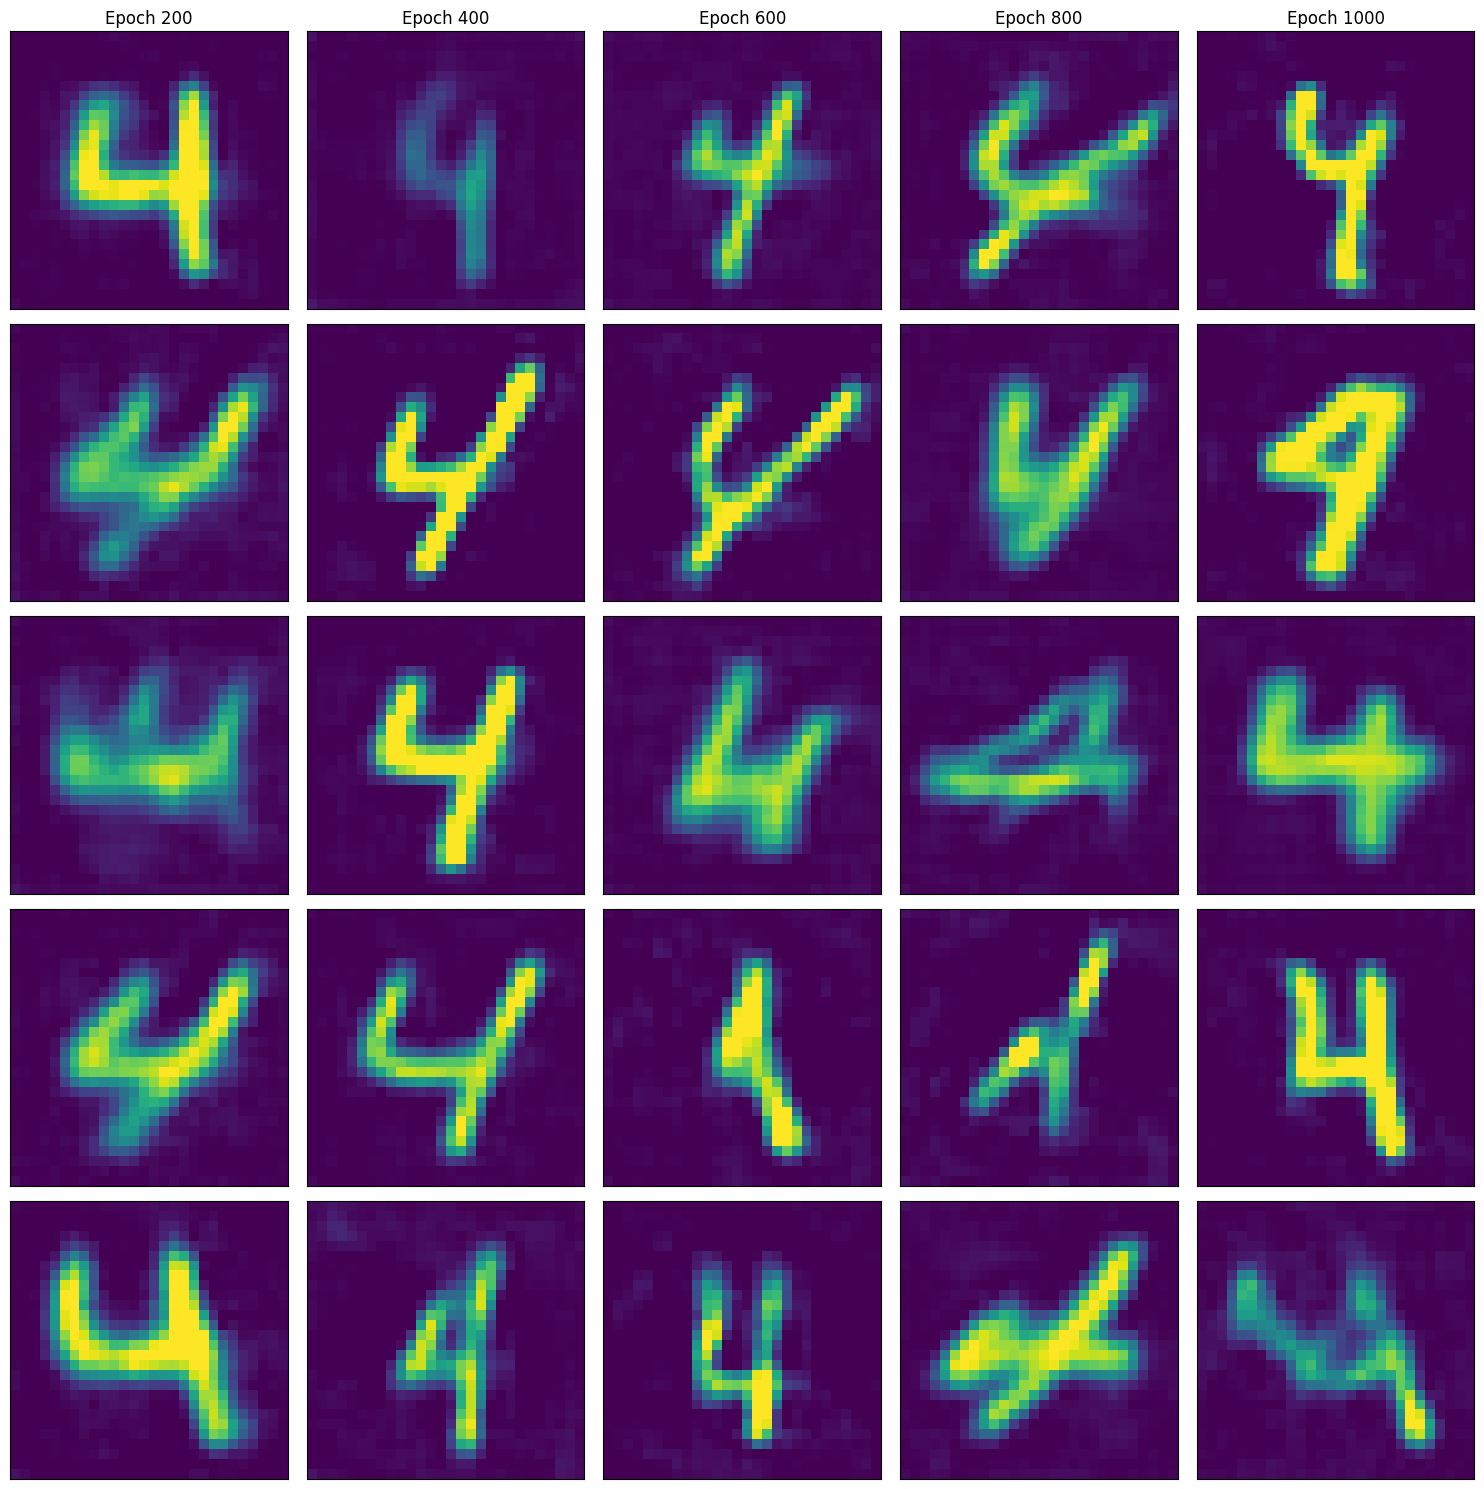

In [ ]:
five_samples_same_model_during_training(fours_fff_snapshots, n_epochs=1000)#, save_path="best_fours_samples.png")

In [ ]:
line1 = plt.plot(fours_fff_metrics["loss"], label="Loss")[0]
plt.yscale("log")
plt.ylabel("Loss")
ax = plt.twinx()
ax.set_yscale("log")
line2 = ax.plot(fours_fff_metrics["fid"][0], fours_fff_metrics["fid"][1], color="red", label="FID")[0]
ax.set_ylabel("FID")
plt.xlabel("Epochs")

lines = [line1,line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels)

ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=10))  # Minor ticks

plt.grid(plt.grid(which='both', linestyle='--', linewidth=0.5))

ax.minorticks_on()


plt.savefig("fours_fff_training.png", dpi=1000)

# FrEIA

In [ ]:
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 256), nn.ReLU(),
                         nn.Linear(256,  dims_out))

finn = Ff.SequenceINN(pixelwidth**2)
for k in range(10):
    finn.append(Fm.AllInOneBlock, cond=0, cond_shape=(10,), subnet_constructor=subnet_fc, permute_soft=False)

finn = finn.to(device)

def freia_sample(self, n, cond=None, num_classes=10):
    if cond == None:
      cond = torch.zeros(n, num_classes).to(device)
    z = torch.randn((n,28*28)).to(device)
    sample, _ = self(z, c=[cond,], rev=True)
    return sample

finn.sample = types.MethodType(freia_sample, finn)

def freia_logprob(self, x, cond=None, verbose=False):
    if cond is None: cond = torch.zeros(x.shape[0], 10).to(device)
    z, ljd = self.forward(x, [cond,])
    latents = - 0.5*torch.sum(z**2, -1) - 0.5 * z.shape[1] * np.log(2*math.pi)
    if verbose:
        return latents + ljd, latents, ljd
    return - 0.5*torch.sum(z**2, -1) + ljd - 0.5 * z.shape[1] * np.log(2*math.pi)

finn.logprob = types.MethodType(freia_logprob, finn)

finn, finn_metrics, finn_snapshots = train_model_mnist(finn,
                                                       model_name="freia",
                                                       digit=4,
                                                       pixelwidth=pixelwidth,
                                                       batchsize=500,
                                                       epochs=60,
                                                       lr=inn_lr,
                                                       calculate_mmd=False,
                                                       calculate_fid=False,
                                                       weight_decay=1e-5,
                                                       conditional_training=True,
                                                       zero_one_range=True)

In [ ]:
five_samples_same_model_during_training(finn_snapshots, n_epochs=6000, save_path="five_samples_during_training_freia_uncond_6000.png")

In [ ]:
print(sum([p.numel() for p in finn.parameters() if p.requires_grad]))

3062240


In [ ]:
line1 = plt.plot(finn_metrics["loss"], label="Loss")[0]
plt.ylabel("Loss")
ax = plt.twinx()
line2 = ax.plot(finn_metrics["mmd"][0], finn_metrics["mmd"][1], color="orange", label="MMD")[0]
ax.set_ylabel("MMD")
plt.xlabel("Epochs")

lines = [line1,line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels)

plt.savefig("freia_mnist_uncond_training.png", dpi=1000)

(10,) (10,) (10,)


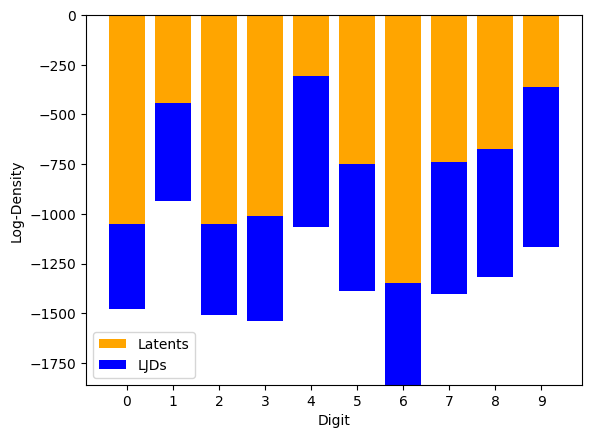

In [ ]:
latent_ljd_bar_plots(finn, verbose=True)

# Different tests for FID

In [ ]:
# undefined: 1. reference_fff.sample
def fid_tests(extractor, batchsize=1000, digit=4, extract_layer=None):

    all_mnist, _ = get_mnist_dataloaders(batchsize=batchsize, pixelwidth=28, digit=None)

    fours, _ = get_mnist_dataloaders(batchsize=batchsize, pixelwidth=28, digit=4)

    ones, _ = get_mnist_dataloaders(batchsize=batchsize, pixelwidth=28, digit=1)

    sevens, _ = get_mnist_dataloaders(batchsize=batchsize, pixelwidth=28, digit=7)

    eights, _ = get_mnist_dataloaders(batchsize=batchsize, pixelwidth=28, digit=8)

    noise = torch.randn((batchsize, 28*28)).to(device)

    bad_fours = reference_fff.sample(batchsize).to(device)

    the_same_four = next(iter(fours))[0][0].repeat(batchsize,1).to(device)

    test_values = []

    # 1 two mnist batches
    test_values.append(calculate_fid(next(iter(all_mnist))[0].to(device), next(iter(all_mnist))[0].to(device), extractor, extract_layer=extract_layer))

    # 1.2 two fours batches
    test_values.append(calculate_fid(next(iter(fours))[0].to(device), next(iter(fours))[0].to(device), extractor, extract_layer=extract_layer))

    # 2 true vs resnet samples
    test_values.append(calculate_fid(next(iter(fours))[0].to(device), bad_fours, extractor, extract_layer=extract_layer))

    # 3 true vs noise
    test_values.append(calculate_fid(next(iter(fours))[0].to(device), noise, extractor, extract_layer=extract_layer))

    # 4 many fours vs one four
    test_values.append(calculate_fid(next(iter(fours))[0].to(device), the_same_four, extractor, extract_layer=extract_layer))

    # 5 ones vs sevens
    test_values.append(calculate_fid(next(iter(ones))[0].to(device), next(iter(sevens))[0].to(device), extractor, extract_layer=extract_layer))

    # 6 ones vs eights
    test_values.append(calculate_fid(next(iter(ones))[0].to(device), next(iter(eights))[0].to(device), extractor, extract_layer=extract_layer))

    return test_values

In [ ]:
for el in [1,2,3]: # 0 gives 12544 features, 1 gives 6272, 2 gives 3136, 3 gives 256
    print(fid_tests(fid_feature_extractor, extract_layer=el, batchsize=1000))

[47.347244, 18.576574, 997.4212, 4029.6943, 2153.193, 1649.8912, 1484.91]
[16.728842, 6.431515, 542.22925, 1850.8878, 801.4468, 736.4992, 662.92786]
[6.2483325, 4.5565643, 359.47006, 783.87415, 550.41565, 281.36053, 250.44028]


In [ ]:
# undefined: 1. reference_fff 2. small_fff
finn_fids = []
reference_fff_fids = []
small_fff_fids = []

for i in range(5):
    print("lit")
    finn_fids.append(get_fid_for_model(finn))
    reference_fff_fids.append(get_fid_for_model(reference_fff))
    small_fff_fids.append(get_fid_for_model(small_fff))

print(finn_fids)
print(reference_fff_fids)
print(small_fff_fids)

lit
lit
lit
lit
lit
[1696.7456, 1281.8026, 1139.5847, 790.0873, 814.2963]
[538.1279, 537.57184, 515.99146, 543.5168, 542.6758]
[398.0, 405.38898, 423.58426, 403.55835, 398.4791]


In [ ]:
print(f"FID for INN:       {np.mean(finn_fids)} +- {np.std(finn_fids)}")
print(f"FID for Reference: {np.mean(reference_fff_fids)} +- {np.std(reference_fff_fids)}")
print(f"FID for Small FFF: {np.mean(small_fff_fids)} +- {np.std(small_fff_fids)}")

FID for INN:       1144.5032958984375 +- 334.2137451171875
FID for Reference: 535.5767822265625 +- 10.074851036071777
FID for Small FFF: 405.8021545410156 +- 9.337124824523926


In [ ]:
zeit = time.time()

get_fid_for_model(small_fff, extract_layer=1)

print(zeit-time.time())

get_fid_for_model(small_fff, extract_layer=2)

print(zeit-time.time())

get_fid_for_model(small_fff, extract_layer=3)

print(zeit-time.time())

-106.96173334121704
-129.87831783294678
-130.84232306480408


# Cross-validate conv-FFFs

In [ ]:
cs = [16, 32, 64]
f1s = [256, 512]
tcs = [True, False]
bns = [True, False]

params_combos = list(product(cs, f1s, tcs, bns))

nparams = []
fids = []
models = []
metrics = []

for params in params_combos:
    c, f1, tc, bn = params
    test_encoder = brazy_encoder(c_small=c,
                            f1_dim=f1,
                            f2_dim=f1*2,
                            batchnorm=bn,
                            third_conv=tc).to(device)
    test_decoder = brazy_decoder(c_small=c,
                            f1_dim=f1,
                            f2_dim=f1*2,
                            batchnorm=bn,
                            third_conv=tc).to(device)


    models.append(FreeFormFlow(test_encoder, test_decoder, device=device, data_dims=pixelwidth**2).to(device))

    nparams.append(sum([p.numel() for p in models[-1].parameters() if p.requires_grad]))

    test_fff, test_fff_metrics, test_fff_snapshots = train_model_mnist(models[-1],
                                                        model_name="fff",
                                                        digit=4,
                                                        pixelwidth=pixelwidth,
                                                        epochs=500,
                                                        lr=0.0008,
                                                        batchsize=500,
                                                        beta_r=beta_r,
                                                        dequantization=None,
                                                        calculate_mmd=False,
                                                        calculate_fid=False,
                                                        dynamic_plot=False)

    fids.append(get_fid_for_model(test_fff))
    metrics.append(test_fff_metrics)
    print(params, fids[-1])

(64, 512, False, False) 526.4828


In [ ]:
for i in range(len(params_combos)):
  print(f"c, f, 3, bn: {params_combos[i]}; nparams: {nparams[i]}; fid: {fids[i]}")

c, f, 3, bn: (16, 256, True, True); nparams: 2722769; fid: 1995.902099609375
c, f, 3, bn: (16, 256, True, False); nparams: 2722577; fid: 1027.608154296875
c, f, 3, bn: (16, 256, False, True); nparams: 1881425; fid: 571.5330810546875
c, f, 3, bn: (16, 256, False, False); nparams: 1881233; fid: 1512.2064208984375
c, f, 3, bn: (16, 512, True, True); nparams: 5919185; fid: 552.2666625976562
c, f, 3, bn: (16, 512, True, False); nparams: 5918993; fid: 924.3717041015625
c, f, 3, bn: (16, 512, False, True); nparams: 4275025; fid: 773.8551025390625
c, f, 3, bn: (16, 512, False, False); nparams: 4274833; fid: 985.9500122070312
c, f, 3, bn: (32, 256, True, True); nparams: 4470417; fid: 4747.19677734375
c, f, 3, bn: (32, 256, True, False); nparams: 4470033; fid: 717.9385986328125
c, f, 3, bn: (32, 256, False, True); nparams: 2714001; fid: 1502.1761474609375
c, f, 3, bn: (32, 256, False, False); nparams: 2713617; fid: 1432.150634765625
c, f, 3, bn: (32, 512, True, True); nparams: 9272465; fid: 525.

# Density prediction

In [ ]:
if fff_architecture == "mlp":
    encoder = MLP(pixelwidth**2,
                  fff_dim,
                  pixelwidth**2,
                  n_hidden_layers=fff_layers,
                  device=device).to(device)
    decoder = MLP(pixelwidth**2,
                  fff_dim,
                  pixelwidth**2,
                  n_hidden_layers=fff_layers,
                  device=device).to(device)
elif fff_architecture == "resnet":
    encoder = resnet(input_dim=pixelwidth**2,
                     hidden_dim=fff_dim,
                     n_blocks=fff_resnet_blocks,
                     output_dim=pixelwidth**2,
                     hidden_layers=fff_layers).to(device)
    decoder = resnet(input_dim=pixelwidth**2,
                     hidden_dim=fff_dim,
                     n_blocks=fff_resnet_blocks,
                     output_dim=pixelwidth**2,
                     hidden_layers=fff_layers).to(device)
elif fff_architecture == "brazy":
    zoencoder = brazy_encoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=fff_dropout).to(device)
    zodecoder = brazy_decoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=fff_dropout).to(device)


zo_fff = FreeFormFlow(zoencoder, zodecoder, device=device, data_dims=pixelwidth**2).to(device)

print(sum([p.numel() for p in zo_fff.parameters() if p.requires_grad]))

zo_fff, zo_fff_metrics, zo_fff_snapshots = train_model_mnist(zo_fff,
                                                    model_name="fff",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    epochs=1000,
                                                    lr=0.0008,
                                                    batchsize=500,
                                                    beta_r=1.,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=False,
                                                    weight_decay=1e-5,
                                                    lr_schedule=False,
                                                    calculate_is=False,
                                                    zero_one_range=True)

RuntimeError: shape '[10, 6272, 128, 7, 7]' is invalid for input of size 62720

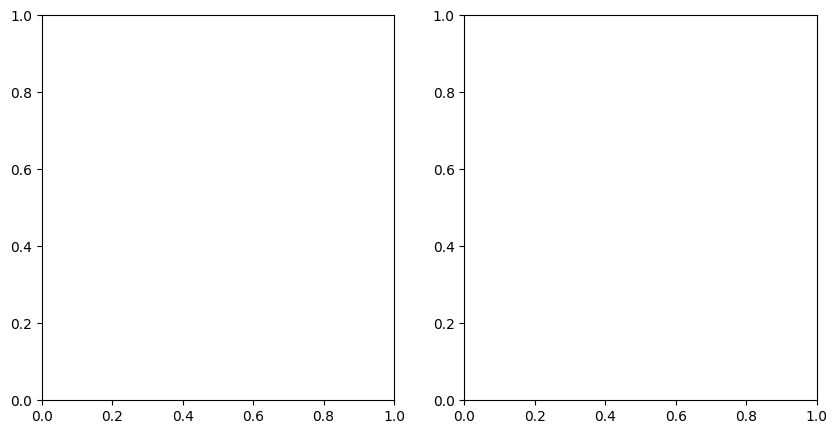

In [ ]:
torch.cuda.empty_cache()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.flatten()

# #zero one range
# zo_fff_densities, zo_fff_latents, zo_fff_ljds = class_density_comparison(fours_fff, 28, verbose=True, zero_one_range=True)
# zo_fff_densities = np.array(zo_fff_densities)
# zo_fff_latents = np.array(zo_fff_latents)
# zo_fff_ljds = np.array(zo_fff_ljds)

# #normalized range
# n_fff_densities, n_fff_latents, n_fff_ljds = class_density_comparison(old_fff, 28, verbose=True, zero_one_range=False)
# n_fff_densities = np.array(n_fff_densities)
# n_fff_latents = np.array(n_fff_latents)
# n_fff_ljds = np.array(n_fff_ljds)

# digits = range(10)

# axs[0].bar(digits, zo_fff_latents, color='orange', label='Latents')  # Bottom bar for latents
# axs[0].bar(digits, zo_fff_ljds, bottom=zo_fff_latents, color='blue', label='LJDs')
# axs[0].set_xticks(digits)
# axs[0].set_xlabel("Digit")
# axs[0].set_ylabel("Log-Density")
# axs[0].set_title(r"Predictions from FFF trained on data in $[0,1]$")

# axs[1].bar(digits, n_fff_latents, color='orange', label='Latents')  # Bottom bar for latents
# axs[1].bar(digits, n_fff_ljds, bottom=n_fff_latents, color='blue', label='LJDs')
# axs[1].set_xticks(digits)
# axs[1].set_xlabel("Digit")
# #axs[1].set_ylabel("Log-Density")
# axs[1].set_title("Predictions from FFF trained on standardized data")

latent_ljd_bar_plots(zo_fff, axs[0], zero_one_range=True, title=r"Predictions from FFF trained on data in $[0,1]^D$", decoder=False)
latent_ljd_bar_plots(fours_fff, axs[1], title=r"Predictions from FFF trained on data in $[-0.447, 2.852]^D$", decoder=False)

plt.tight_layout()

#plt.savefig("fff_density_comparison.png", dpi=1000)

(10,) (10,) (10,)
(10,) (10,) (10,)


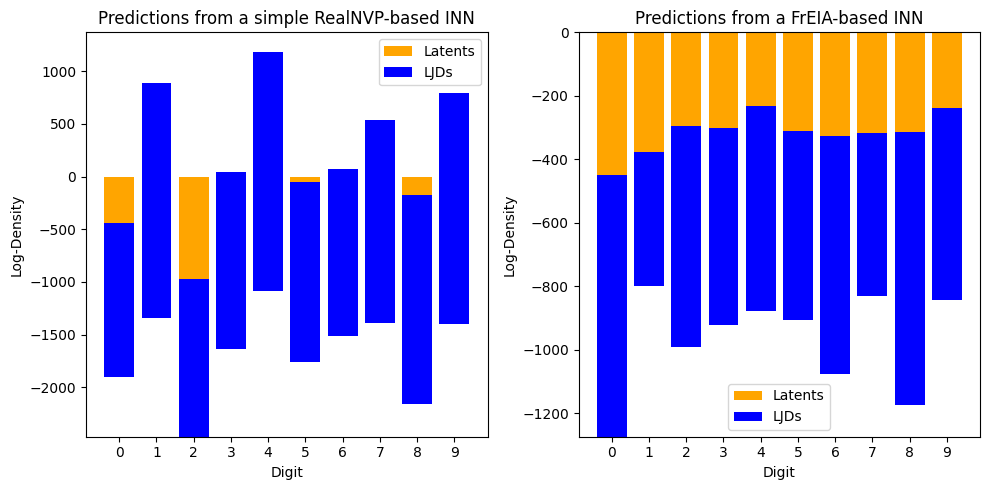

In [ ]:
torch.cuda.empty_cache()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.flatten()



latent_ljd_bar_plots(inn, axs[0], title=r"Predictions from a simple RealNVP-based INN", zero_one_range=True)
latent_ljd_bar_plots(finn, axs[1], title=r"Predictions from a FrEIA-based INN", zero_one_range=True)

plt.tight_layout()

plt.savefig("inn_density_comparison.png", dpi=1000)

(10,) (10,) (10,)


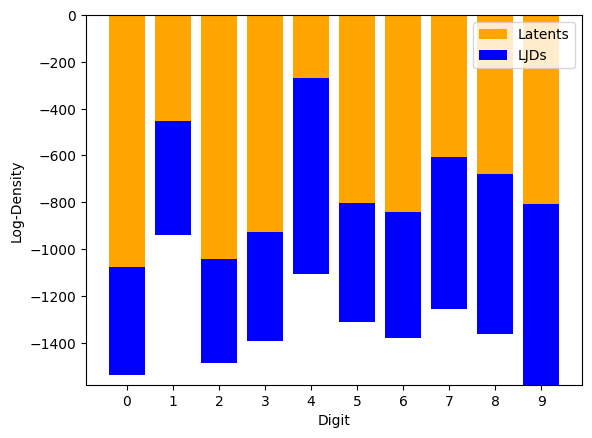

In [ ]:
latent_ljd_bar_plots(finn, verbose=True)

# Conditional FFF

In [ ]:
enc = cond_conv_encoder(c_small=64, f1_dim=1024, f2_dim=1024, batchnorm=False, third_conv=True).to(device)
dec = cond_conv_decoder(c_small=64, f1_dim=1024, f2_dim=1024, batchnorm=False, third_conv=True).to(device)

cfff = condFreeFormFlow(enc, dec, data_dims=28*28).to(device)

cfff, cfff_metrics, cfff_snapshots = train_model_mnist(cfff,
                                                      model_name="fff",
                                                      digit=None,
                                                      conditional_training=True,
                                                      batchsize=500,
                                                      epochs=4000,
                                                      lr=0.0008,
                                                      calculate_mmd=False,
                                                      calculate_fid=True,
                                                      beta_r=80.,
                                                      dynamic_plot=True)

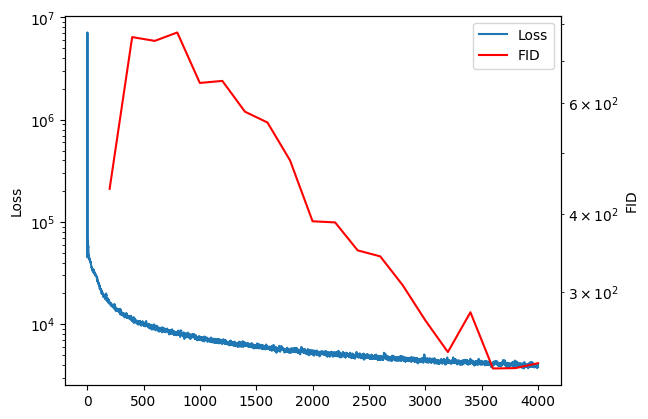

In [ ]:
line1 = plt.plot(cfff_metrics["loss"], label="Loss")[0]
plt.yscale("log")
plt.ylabel("Loss")
ax = plt.twinx()
ax.set_yscale("log")
line2 = ax.plot(cfff_metrics["fid"][0], cfff_metrics["fid"][1], color="red", label="FID")[0]
ax.set_ylabel("FID")
plt.xlabel("Epochs")

lines = [line1,line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels)

# plt.savefig("cfff_mnist_uncond_training_on_all_mnist.png", dpi=1000)

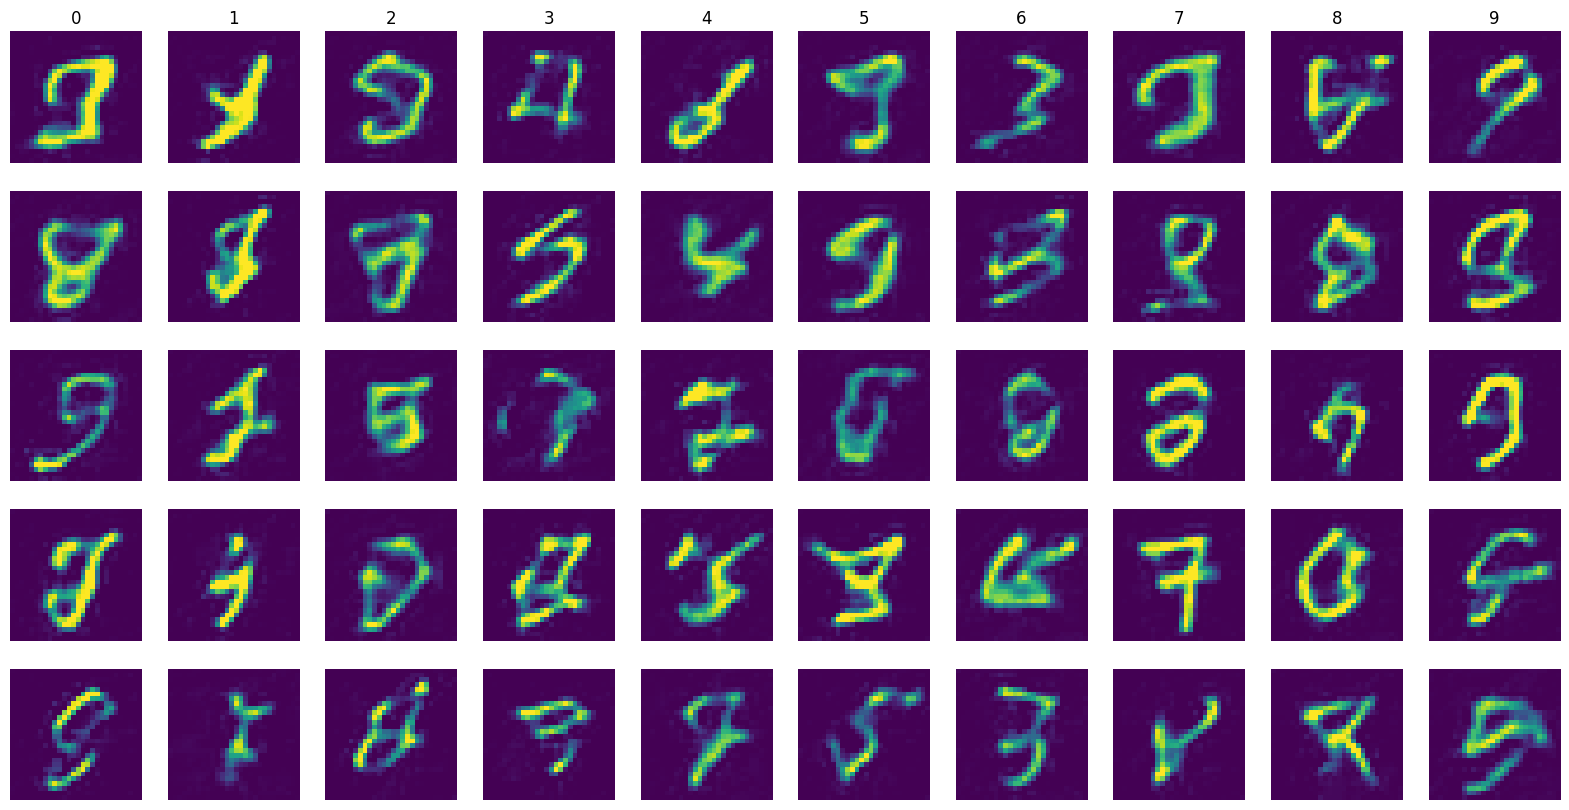

In [ ]:
fig, axs = plt.subplots(5,10,figsize=(20,10))
for digit in range(10):
  for i in range(5):
    sample = cfff.sample(1, torch.nn.functional.one_hot(torch.Tensor([digit,]).long().cuda(), num_classes=10)).cpu().detach().numpy().reshape((28,28))
    axs[i][digit].imshow(sample,vmin=-0.424,vmax=2.832)
    axs[i][digit].axis('off')
    axs[i][digit].set_xticks([])
    axs[i][digit].set_yticks([])
    if i == 0:
      axs[i][digit].set_title(f"{digit}")
plt.savefig("conditional_fff_samples.png", dpi=1000)

# Save models and 2d pca clusters

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# undefined:1. fff
mnist_loader, _ = get_mnist_dataloaders(batchsize=10000, pixelwidth=28, digit=None)
data, labels = next(iter(mnist_loader))
data = data.to(device)
labels = labels.cpu().detach().numpy()

latents = fff(data).cpu().detach().numpy()
print(latents.shape)

(10000, 784)


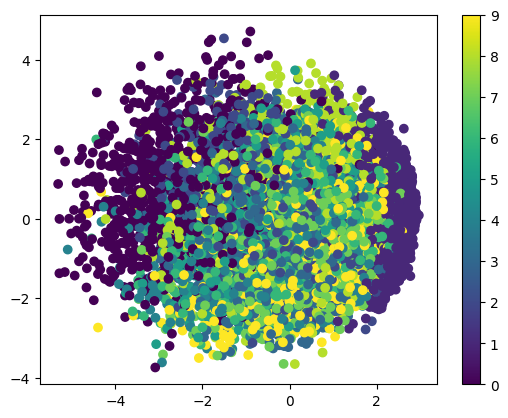

In [ ]:
pca = PCA(n_components=2)
pca.fit(latents)

data_reduced = pca.fit_transform(latents)
plt.scatter(data_reduced[:,0], data_reduced[:,1], c=labels)
plt.colorbar()

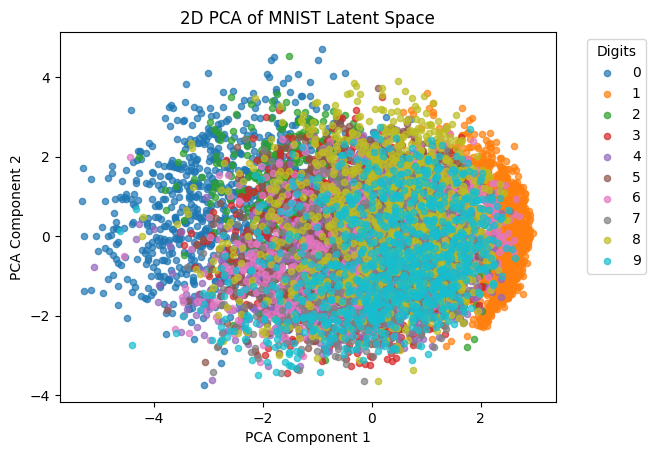

<Figure size 640x480 with 0 Axes>

In [ ]:
for digit in range(10):
    # Select data points that belong to the current label
    idx = labels == digit
    plt.scatter(data_reduced[idx, 0], data_reduced[idx, 1], label=str(digit), s=20, alpha=0.7)

plt.legend(title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA of MNIST Latent Space")
plt.show()

plt.savefig("pca_mnist_latents.png")

In [ ]:
torch.save(cfff, "cfff.pt")

# Dropout experiment

In [ ]:
pd_models = []

for pd in [0.0, 0.05, 0.1, 0.2, 0.4]:
    encoder = brazy_encoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=pd).to(device)
    decoder = brazy_decoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=pd).to(device)


    pd_fff = FreeFormFlow(encoder, decoder, device=device, data_dims=pixelwidth**2).to(device)

    pd_fff, _, _ = train_model_mnist(pd_fff,
                                    model_name="fff",
                                    digit=4,
                                    pixelwidth=pixelwidth,
                                    epochs=1000,
                                    lr=0.0008,
                                    batchsize=500,
                                    beta_r=1.,
                                    ridge=None,
                                    dequantization=None,
                                    calculate_mmd=False,
                                    calculate_fid=True,
                                    weight_decay=1e-5,
                                    lr_schedule=False,
                                    calculate_is=False,
                                    zero_one_range=True)
    pd_models.append(pd_fff)

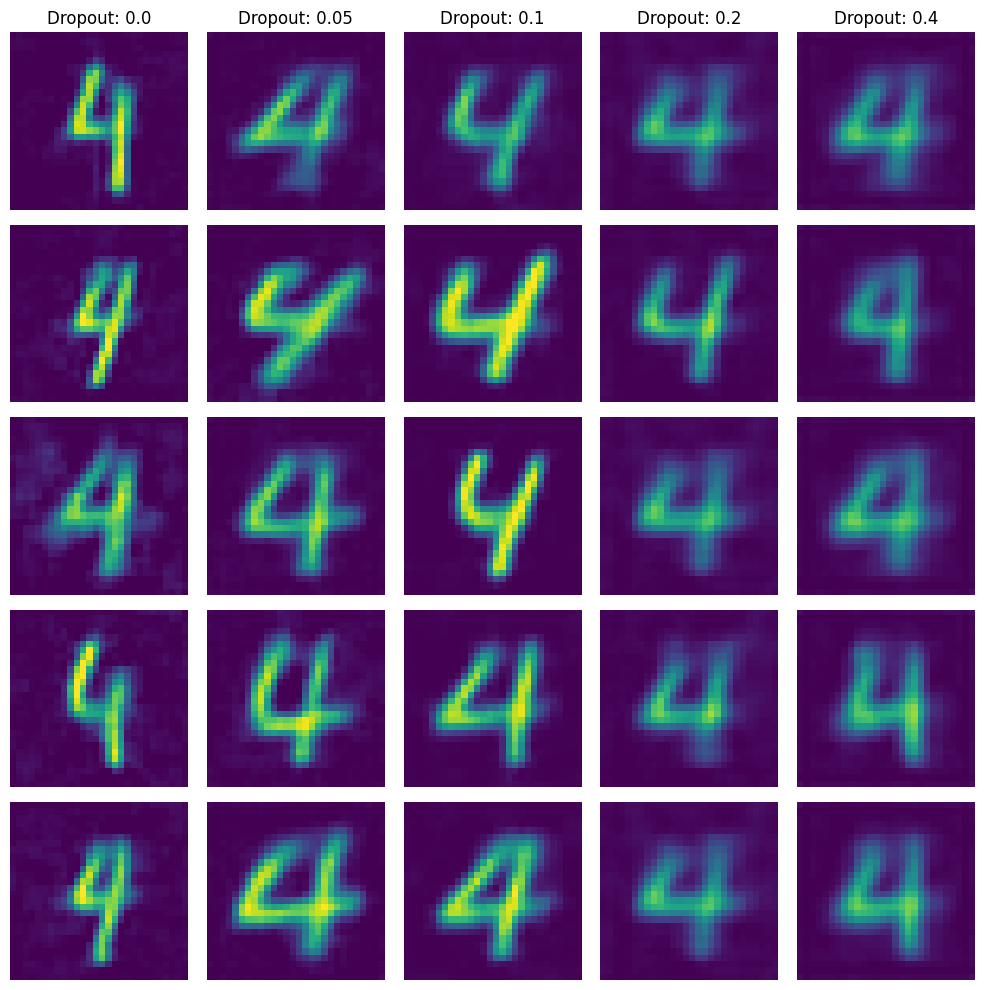

In [ ]:
fig, axs = plt.subplots(5,5,figsize=(10,10))
pds = [0.0, 0.05, 0.1, 0.2, 0.4]

for model_idx in range(5):
  samples = pd_models[model_idx].sample(5).cpu().detach().numpy()
  for sample_idx in range(5):
    if sample_idx == 0:
      axs[sample_idx][model_idx].set_title(f"Dropout: {pds[model_idx]}")
    axs[sample_idx][model_idx].imshow(samples[sample_idx].reshape((28,28)),vmin=0.,vmax=1.)
    axs[sample_idx][model_idx].axis('off')
    axs[sample_idx][model_idx].set_xticks([])
    axs[sample_idx][model_idx].set_yticks([])

plt.tight_layout()
plt.savefig("dropout_samples.png", dpi=1000)

In [ ]:
fids_dropout = []
for model in pd_models:
    fids_dropout.append(get_fid_for_model(model))

# (-0.424, 2.823) range

In [ ]:
if fff_architecture == "mlp":
    encoder = MLP(pixelwidth**2,
                  fff_dim,
                  pixelwidth**2,
                  n_hidden_layers=fff_layers,
                  device=device).to(device)
    decoder = MLP(pixelwidth**2,
                  fff_dim,
                  pixelwidth**2,
                  n_hidden_layers=fff_layers,
                  device=device).to(device)
elif fff_architecture == "resnet":
    encoder = resnet(input_dim=pixelwidth**2,
                     hidden_dim=fff_dim,
                     n_blocks=fff_resnet_blocks,
                     output_dim=pixelwidth**2,
                     hidden_layers=fff_layers).to(device)
    decoder = resnet(input_dim=pixelwidth**2,
                     hidden_dim=fff_dim,
                     n_blocks=fff_resnet_blocks,
                     output_dim=pixelwidth**2,
                     hidden_layers=fff_layers).to(device)
elif fff_architecture == "brazy":
    encoder = brazy_encoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=fff_dropout).to(device)
    decoder = brazy_decoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=fff_dropout).to(device)


old_fff = FreeFormFlow(encoder, decoder, device=device, data_dims=pixelwidth**2).to(device)

print(sum([p.numel() for p in old_fff.parameters() if p.requires_grad]))

old_fff, old_fff_metrics, old_fff_snapshots = train_model_mnist(old_fff,
                                                    model_name="fff",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    epochs=1000,
                                                    lr=0.0008,
                                                    batchsize=500,
                                                    beta_r=1.,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=True,
                                                    weight_decay=1e-5,
                                                    lr_schedule=False,
                                                    calculate_is=False,
                                                    zero_one_range=False)

# Latent sanity check

In [ ]:
for digit in range(10):
  loader, _ = get_mnist_dataloaders(batchsize=10, pixelwidth=28, digit=digit)
  data, labels = next(iter(loader))
  data = data.to(device)
  latents = old_fff(data).cpu().detach().numpy()
  ljds = old_fff.ljd(data)[1].cpu().detach().numpy()
  print(ljds.shape)
  z_norm = np.sum(latents**2, axis=1)#
  print(f"{digit}: {z_norm.mean():.3f}, {ljds.mean()/784}")

(10, 1)
0: 8.527, -18.378475267059947
(10, 1)
1: 3.134, -18.86618353396046
(10, 1)
2: 3.834, -18.490137216996175
(10, 1)
3: 2.720, -18.596085528938136
(10, 1)
4: 3.920, -18.862835319674744
(10, 1)
5: 2.997, -18.582828443877553
(10, 1)
6: 5.028, -18.492394272161988
(10, 1)
7: 4.484, -18.715398048867986
(10, 1)
8: 3.160, -18.616323042889032
(10, 1)
9: 2.325, -18.993895238759567


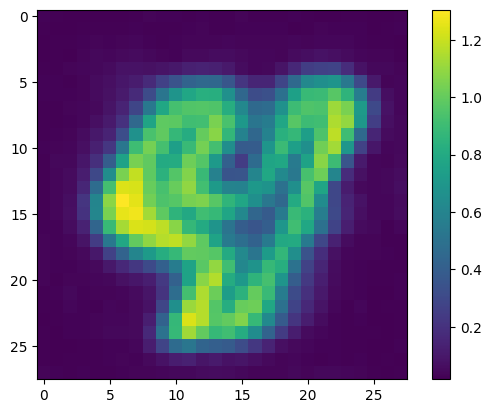

In [ ]:
four_loader, _ = get_mnist_dataloaders(1000, 28, digit=4)
fours = next(iter(four_loader))[0].to(device)
latents = fours_fff.decoder(fours).cpu().detach().numpy()
stddevs = np.std(latents, axis=0)
plt.imshow(stddevs.reshape((28,28)))
plt.colorbar()

In [ ]:
if fff_architecture == "mlp":
    encoder = MLP(pixelwidth**2,
                  fff_dim,
                  pixelwidth**2,
                  n_hidden_layers=fff_layers,
                  device=device).to(device)
    decoder = MLP(pixelwidth**2,
                  fff_dim,
                  pixelwidth**2,
                  n_hidden_layers=fff_layers,
                  device=device).to(device)
elif fff_architecture == "resnet":
    encoder = resnet(input_dim=pixelwidth**2,
                     hidden_dim=fff_dim,
                     n_blocks=fff_resnet_blocks,
                     output_dim=pixelwidth**2,
                     hidden_layers=fff_layers).to(device)
    decoder = resnet(input_dim=pixelwidth**2,
                     hidden_dim=fff_dim,
                     n_blocks=fff_resnet_blocks,
                     output_dim=pixelwidth**2,
                     hidden_layers=fff_layers).to(device)
elif fff_architecture == "brazy":
    trialencoder = brazy_encoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=fff_dropout).to(device)
    trialdecoder = brazy_decoder(c_small=fff_c_small,
                            f1_dim=fff_f1_dim,
                            f2_dim=fff_f2_dim,
                            third_conv=third_convolutional_layer,
                            batchnorm=fff_batchnorm,
                            p_dropout=fff_dropout).to(device)


trial_fff = FreeFormFlow(trialencoder, trialdecoder, device=device, data_dims=pixelwidth**2).to(device)

print(sum([p.numel() for p in trial_fff.parameters() if p.requires_grad]))

trial_fff, trial_fff_metrics, trial_fff_snapshots = train_model_mnist(trial_fff,
                                                    model_name="fff",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    epochs=1000,
                                                    lr=0.0008,
                                                    batchsize=500,
                                                    beta_r=10.,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=False,
                                                    weight_decay=1e-5,
                                                    lr_schedule=False,
                                                    calculate_is=False,
                                                    zero_one_range=False)

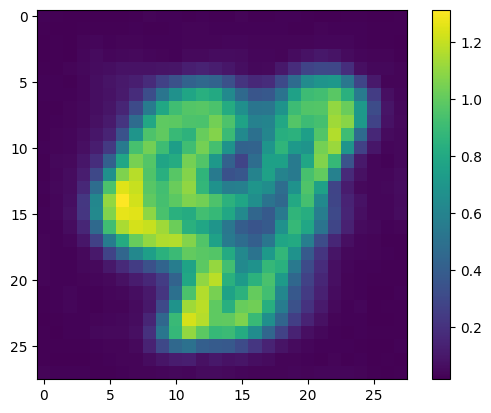

In [ ]:
four_loader, _ = get_mnist_dataloaders(2000, 28, digit=4)
fours = next(iter(four_loader))[0].to(device)
beta1_latents = fours_fff.decoder(fours).cpu().detach().numpy()
beta1_stddevs = np.std(beta1_latents, axis=0)
plt.imshow(beta1_stddevs.reshape((28,28)))
plt.colorbar()

In [ ]:
beta1_mean_latents = np.mean(fours.cpu().detach().numpy(), axis=0)
beta1_centered_latents = beta1_latents - beta1_mean_latents

# Compute the covariance matrix
beta1_cov_matrix = np.cov(beta1_centered_latents, rowvar=False)  # Set rowvar=False to treat columns as variables

# Determine the rank of the covariance matrix
beta1_rank = np.linalg.matrix_rank(beta1_cov_matrix)

print(f"Rank of the covariance matrix: {beta1_rank}")

Rank of the covariance matrix: 784


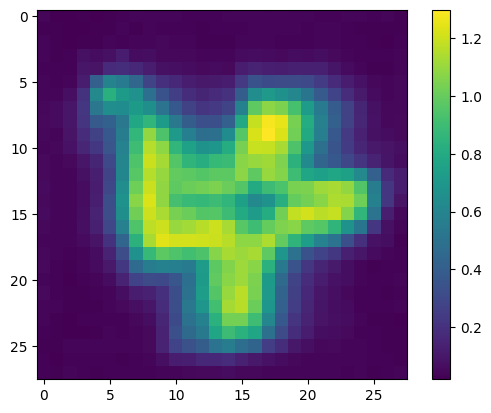

In [ ]:
beta10_latents = trial_fff.decoder(fours).cpu().detach().numpy()
beta10_stddevs = np.std(beta10_latents, axis=0)
plt.imshow(beta10_stddevs.reshape((28,28)))
plt.colorbar()

In [ ]:
beta10_mean_latents = np.mean(beta10_latents, axis=0)
beta10_centered_latents = beta10_latents - beta10_mean_latents

# Compute the covariance matrix
beta10_cov_matrix = np.cov(beta10_centered_latents, rowvar=False)  # Set rowvar=False to treat columns as variables

# Determine the rank of the covariance matrix
beta10_rank = np.linalg.matrix_rank(beta10_cov_matrix)

print(f"Rank of the covariance matrix: {beta10_rank}")

Rank of the covariance matrix: 784


# Testing if resnet has better logprobs

In [ ]:
rencoder = resnet(input_dim=pixelwidth**2,
                  hidden_dim=fff_dim,
                  n_blocks=fff_resnet_blocks,
                  output_dim=pixelwidth**2,
                  hidden_layers=fff_layers).to(device)
rdecoder = resnet(input_dim=pixelwidth**2,
                  hidden_dim=fff_dim,
                  n_blocks=fff_resnet_blocks,
                  output_dim=pixelwidth**2,
                  hidden_layers=fff_layers).to(device)

resnet_fff = FreeFormFlow(rencoder, rdecoder, device=device, data_dims=pixelwidth**2).to(device)

print(sum([p.numel() for p in resnet_fff.parameters() if p.requires_grad]))

resnet_fff, resnet_fff_metrics, resnet_fff_snapshots = train_model_mnist(resnet_fff,
                                                    model_name="fff",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    epochs=1000,
                                                    lr=0.0001,
                                                    batchsize=500,
                                                    beta_r=1.,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=False,
                                                    weight_decay=1e-5,
                                                    lr_schedule=False,
                                                    calculate_is=False,
                                                    zero_one_range=False)

# 50 dimension type shit

In [ ]:
pca_dim = 100

encoder = MLP(pca_dim,
              fff_dim,
              pca_dim,
              n_hidden_layers=fff_layers,
              device=device).to(device)
decoder = MLP(pca_dim,
              fff_dim,
              pca_dim,
              n_hidden_layers=fff_layers,
              device=device).to(device)

pca_resnet_fff = FreeFormFlow(encoder, decoder, device=device, data_dims=pca_dim).to(device)

pca = PCA(n_components=100)
big_fours_loader, _ = get_mnist_dataloaders(10000, pixelwidth=28, digit=4)
all_fours = next(iter(big_fours_loader))[0]
pca.fit(all_fours)

print(sum([p.numel() for p in pca_resnet_fff.parameters() if p.requires_grad]))

pca_resnet_fff, pca_resnet_fff_metrics, pca_resnet_fff_snapshots = train_model_mnist(pca_resnet_fff,
                                                    model_name="fff",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    epochs=1000,
                                                    lr=0.0001,
                                                    batchsize=500,
                                                    beta_r=800.,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=False,
                                                    weight_decay=1e-5,
                                                    lr_schedule=False,
                                                    calculate_is=False,
                                                    calculate_logprobs=True,
                                                    zero_one_range=False,
                                                    pca_instance=pca,
                                                    reconstruction_error_from_pca=True)

(10,) (10,) (10,)


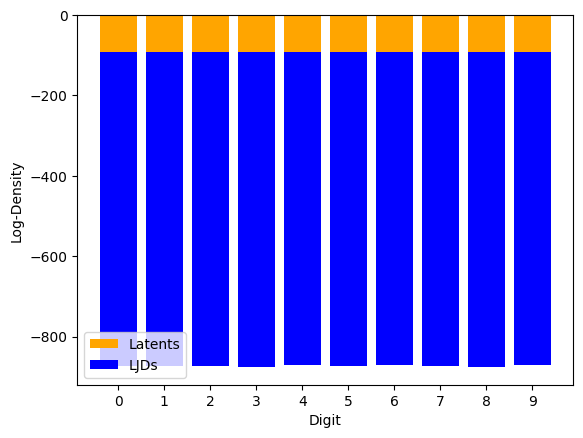

In [ ]:
fig, axs = plt.subplots()
latent_ljd_bar_plots(pca_resnet_fff, axs, pca=pca)

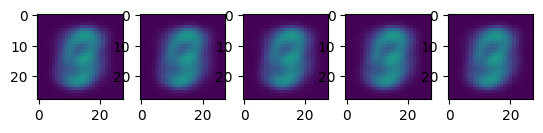

In [ ]:
pca_samples = pca_resnet_fff.sample(5).cpu().detach().numpy()
rec_images = pca.inverse_transform(pca_samples)
fig, axs = plt.subplots(1,5)
axs = axs.flatten()
for i in range(5):
  axs[i].imshow(rec_images[i].reshape((28,28)), vmin=-0.447, vmax=2.852)


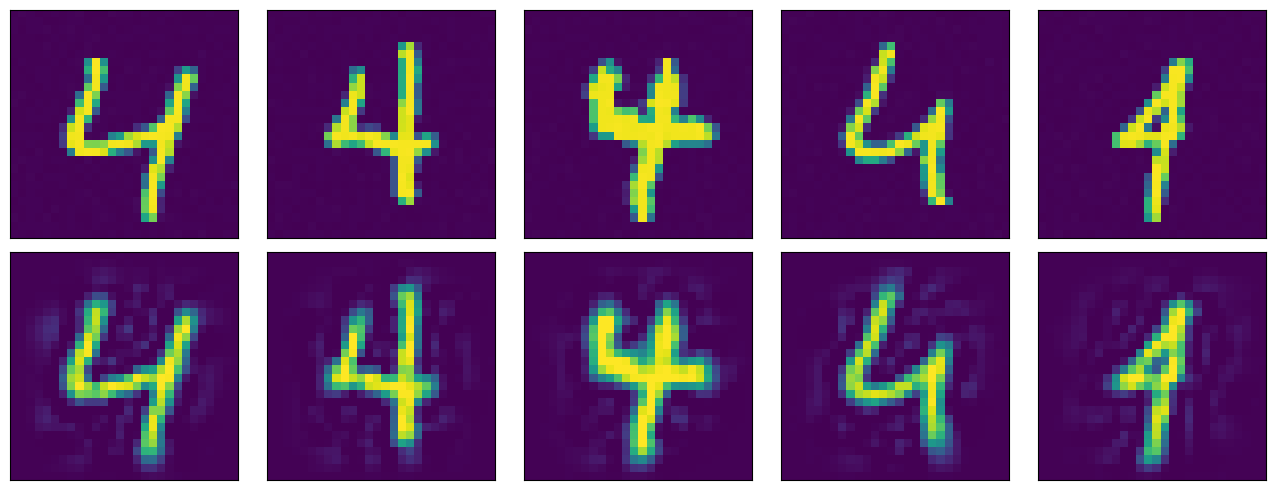

In [ ]:
pca = PCA(n_components=100)
mnist_loader, _ = get_mnist_dataloaders(10000, pixelwidth=28, digit=None)
fours_loader, _ = get_mnist_dataloaders(10000, pixelwidth=28, digit=4)
mnist_samples = next(iter(mnist_loader))[0]
fours_samples = next(iter(fours_loader))[0]
pca.fit(mnist_samples)

fig, axs = plt.subplots(2,5,figsize=(13,5))
fours = fours_samples[:5]
for i in range(5):
  four = fours[i].detach().cpu().numpy().reshape(1,-1)
  recon = pca.inverse_transform(pca.transform(four))
  axs[0][i].imshow(four.reshape((28,28)), vmin=-0.447, vmax=2.852)
  axs[1][i].imshow(recon.reshape((28,28)), vmin=-0.447, vmax=2.852)
  axs[0][i].set_xticks([])
  axs[0][i].set_yticks([])
  axs[1][i].set_xticks([])
  axs[1][i].set_yticks([])

plt.tight_layout()

plt.savefig("pca_reconstructions.png", dpi=1000)

# Cond-FFF 2.0

In [ ]:
# Train ImprovedCNN
batch_size = 64
learning_rate = 0.001
epochs = 5

# DataLoader for batching
cnn_train_loader, cnn_test_loader = get_mnist_dataloaders(batchsize=batch_size, pixelwidth=28, digit=None)

# Initialize the improved CNN model
acfff_prob_teacher = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(acfff_prob_teacher.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    acfff_prob_teacher.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(cnn_train_loader):
        # Move to device if available (GPU support)
        inputs, labels = inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = acfff_prob_teacher(inputs, extract_layer=20)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print statistics every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{batch_idx + 1}/{len(cnn_train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
acfff_prob_teacher.is_trained = True

test_model(acfff_prob_teacher, cnn_test_loader)

Epoch [1/5], Step [100/938], Loss: 0.4343
Epoch [1/5], Step [200/938], Loss: 0.1280
Epoch [1/5], Step [300/938], Loss: 0.1149
Epoch [1/5], Step [400/938], Loss: 0.0818
Epoch [1/5], Step [500/938], Loss: 0.0674
Epoch [1/5], Step [600/938], Loss: 0.0560
Epoch [1/5], Step [700/938], Loss: 0.0710
Epoch [1/5], Step [800/938], Loss: 0.0618
Epoch [1/5], Step [900/938], Loss: 0.0693
Epoch [2/5], Step [100/938], Loss: 0.0443
Epoch [2/5], Step [200/938], Loss: 0.0352
Epoch [2/5], Step [300/938], Loss: 0.0451
Epoch [2/5], Step [400/938], Loss: 0.0474
Epoch [2/5], Step [500/938], Loss: 0.0503
Epoch [2/5], Step [600/938], Loss: 0.0506
Epoch [2/5], Step [700/938], Loss: 0.0456
Epoch [2/5], Step [800/938], Loss: 0.0530
Epoch [2/5], Step [900/938], Loss: 0.0447
Epoch [3/5], Step [100/938], Loss: 0.0299
Epoch [3/5], Step [200/938], Loss: 0.0356
Epoch [3/5], Step [300/938], Loss: 0.0421
Epoch [3/5], Step [400/938], Loss: 0.0326
Epoch [3/5], Step [500/938], Loss: 0.0359
Epoch [3/5], Step [600/938], Loss:

In [ ]:
encoder = cond_conv_encoder(output_dim=794,
                        c_small=32,
                        f1_dim=512,
                        f2_dim=1024,
                        third_conv=third_convolutional_layer,
                        batchnorm=False,
                        p_dropout=0.1,
                        cond_dim=10).to(device)
decoder = cond_conv_decoder(c_small=32,
                        f1_dim=512,
                        f2_dim=1024,
                        third_conv=third_convolutional_layer,
                        batchnorm=False,
                        p_dropout=0.1,
                        cond_dim=10).to(device)


cond_fff = condFreeFormFlow(encoder, decoder, device=device, data_dims=pixelwidth**2, cond_dim=10).to(device)

print(sum([p.numel() for p in cond_fff.parameters() if p.requires_grad]))

cond_fff, cond_fff_metrics, cond_fff_snapshots = train_model_mnist(cond_fff,
                                                    model_name="fff",
                                                    digit=None,
                                                    pixelwidth=pixelwidth,
                                                    epochs=5000,
                                                    lr=0.0008,
                                                    batchsize=200,
                                                    beta_r=1.,
                                                    beta_a=1.,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=False,
                                                    calculate_is=False,
                                                    check_acfff_classification_quality=True,
                                                    weight_decay=1e-5,
                                                    lr_schedule=True,
                                                    conditional_training=True,
                                                    zero_one_range=False,
                                                    dynamic_plot=True)

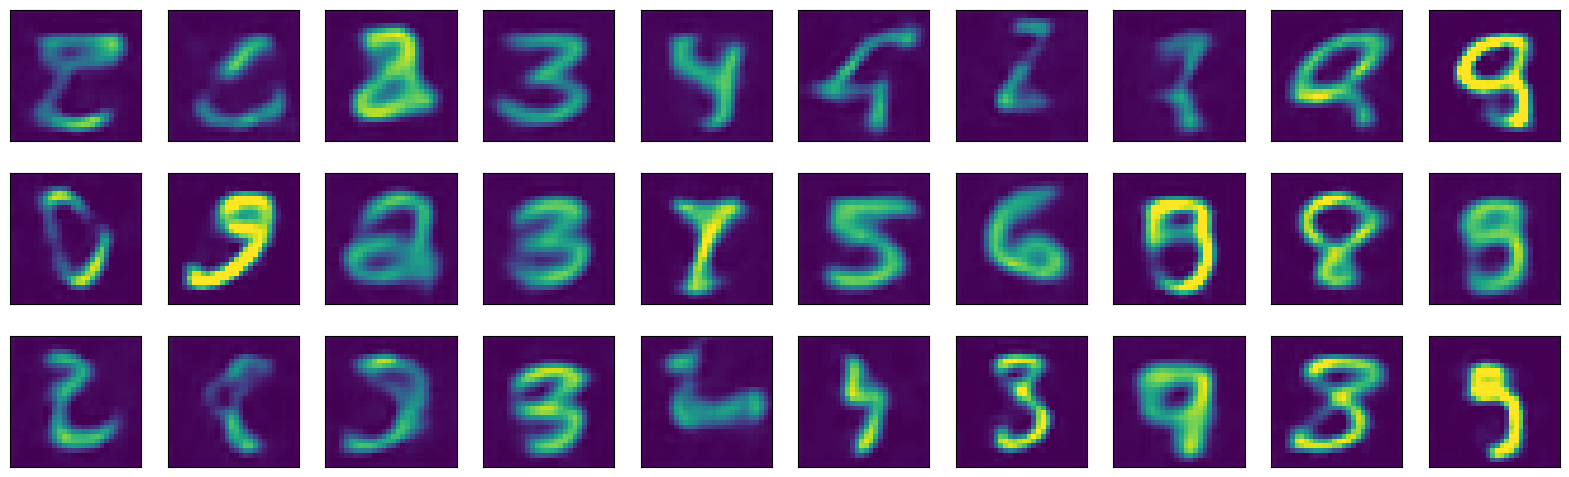

In [ ]:
plot_all_classes(cond_fff)
plt.savefig("cond_fff_all_digits.pdf", dpi=400)

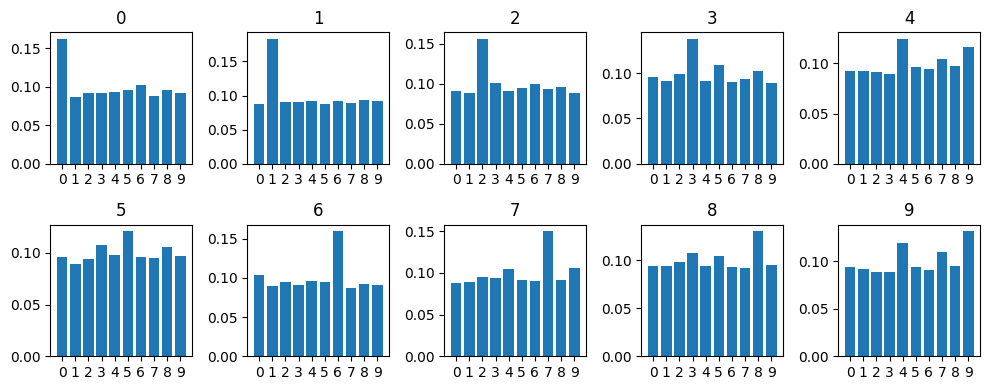

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(10,4))
axs = axs.flatten()

digits_range = range(10)

for digit in digits_range:
  digit_loader, _ = get_mnist_dataloaders(batchsize=50, pixelwidth=28, digit=digit)
  digits = next(iter(digit_loader))[0].to(device)
  cond = torch.zeros(50, 10).to(device)
  cnn_preds = cond_fff(digits, cond)[:,-10:]
  probs = torch.softmax(cnn_preds, axis=1).cpu().detach().numpy()
  mean_probs = np.mean(probs, axis=0)
  axs[digit].bar(digits_range, mean_probs)
  axs[digit].set_title(f"{digit}")
  axs[digit].set_xticks(digits_range)

plt.tight_layout()

plt.savefig("cfff_classification_barplots.png", dpi=1000)

In [ ]:
digit_batches = []

for digit in range(10):
  batch_loader, _ = get_mnist_dataloaders(500, pixelwidth=28, digit=digit)
  batch = next(iter(batch_loader))[0].to(device)
  digit_batches.append(batch)

In [ ]:
for digit in range(10):
  cond = torch.nn.functional.one_hot(digit*torch.ones(500).long(), num_classes=10).to(device)
  sample_batch = cond_fff.sample(500, cond=cond)
  print(calculate_fid(real_batch=digit_batches[digit], synthetic_batch=sample_batch, feature_extractor=acfff_prob_teacher))

4954.383
2318.308
5780.0757
5267.3135
4090.149
5573.279
5068.765
3776.6187
5862.0674
4496.51
